In [381]:
# standard python utilities
import os
import sys
import glob
import pandas as pd
import numpy as np
import calendar
import time

# standard python plotting utilities
import matplotlib as mpl
import matplotlib.pyplot as plt

# standard geospatial python utilities
import pyproj # for converting proj4string
import shapely
import geopandas as gpd
import rasterio

# mapping utilities
import contextily as ctx
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm

In [382]:

# run installed version of flopy or add local path
try:
    import flopy
    from flopy.discretization.structuredgrid import StructuredGrid
    from flopy.utils.reference import SpatialReference
    from flopy.utils import Raster
except:
    import flopy
    fpth = os.path.abspath(os.path.join('..', '..'))
    sys.path.append(fpth)
    from flopy.discretization.structuredgrid import StructuredGrid
    from flopy.utils.reference import SpatialReference
    from flopy.utils import Raster
from flopy.utils.gridgen import Gridgen
from flopy.utils import OptionBlock
import flopy.utils.binaryfile as bf


print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('flopy version: {}'.format(flopy.__version__))

3.7.7 (default, May  6 2020, 11:45:54) [MSC v.1916 64 bit (AMD64)]
numpy version: 1.19.2
matplotlib version: 3.3.1
flopy version: 3.3.0


In [385]:
## Set up directory referencing
# Package data
gwfm_dir = os.path.dirname(os.path.dirname(os.getcwd()))

In [386]:
from flopy.utils.geometry import Polygon, LineString, Point
# Original model domain, 44.7 deg angle
# m_domain = gpd.read_file(gwfm_dir+'\\GWModelDomain_UTM10N\\GWModelDomain_Rec_UTM10N.shp')
# New model domain 52.9 deg
m_domain = gpd.read_file(gwfm_dir+'\\NewModelDomain\\GWModelDomain_52_9deg_UTM10N_WGS84.shp')

# Need to check this when changing model domains
xul, yul = list(m_domain.geometry.values[0].exterior.coords)[1]
list(m_domain.geometry.values[0].exterior.coords)
# m_domain.geometry.values[0].exterior

[(645500.0, 4227700.0),
 (629548.3214234954, 4239764.159754906),
 (657295.8888597784, 4276453.020480867),
 (673247.567436283, 4264388.860725961),
 (645500.0, 4227700.0)]

According to Flopy GitHub "Technically you need to create both a SpatialReference object and a ModelGrid object, but in practice the code looks very similar and can easily be implemented in one line."
WGS84 Zone 10N has EPSG: 32610  
Lower left corner of model is   
Zone 10 N  
Easting: 661211.18 m E  
Northing: 4249696.50 m N  
angle is approximate 53 degrees  

In [388]:
# m.modelgrid.set_coord_info(xoff=xoff, yoff=yoff, proj4='EPSG:32610', angrot=angrot)
mg = m.modelgrid
# Write model grid to shapefile for later use
# mg.write_shapefile(gwfm_dir+'/DIS_data/grid/grid.shp', epsg = '32610')
# mg.write_shapefile(gwfm_dir+'/DIS_data/44_7_grid/44_7_grid.shp', epsg = '32610')


In [389]:
sensors = gpd.read_file(gwfm_dir+"/DEM_data/allsensor_latlong.csv")
sensors.Latitude = sensors.Latitude.astype(np.float64)
sensors.Longitude = sensors.Longitude.astype(np.float64)
sensors.geometry = gpd.points_from_xy(sensors.Longitude, sensors.Latitude)
sensors.crs = 'epsg:4326'
sensors = sensors.to_crs('epsg:32610')

In [390]:
# import contextily as ctx
# fig, ax = plt.subplots(figsize = (10,10))
# mg.plot(ax=ax, alpha = 0.3)
# sensors.plot(ax =ax)

# ctx.add_basemap(ax, source = ctx.providers.Esri.WorldImagery, crs='epsg:26910', alpha = 0.6)
# # ctx.add_basemap(ax, source = ctx.providers.Esri.WorldStreetMap, crs=tg.crs.to_string())

# plt.xlabel('Easting (m)')
# plt.ylabel('Northing (m)')
# plt.savefig('Plots/Model_SFR_UZF_progress/Model_grid_overlay_satellite.png', dpi = 300)

In [391]:
# Load model grid as geopandas object
grid_p = gpd.read_file(gwfm_dir+'/DIS_data/grid/grid.shp')
# grid_p = gpd.read_file(gwfm_dir+'/DIS_data/44_7_grid/44_7_grid.shp')


# Find Michigan Bar location
mb_gpd = sensors[sensors.Sensor_id == "MI_Bar"]
mb_grid = gpd.sjoin(mb_gpd, grid_p, how = 'left', op = 'intersects')

In [392]:
# Get vertexes of model domain
# ll = mg.get_coords(0, 0) #lower left
# lr = mg.get_coords(nrow*delr, 0) #lower right
# ur = mg.get_coords(nrow*delr, ncol*delc) #upper right
# ul = mg.get_coords(0, ncol*delc) #upper left
ll = mg.get_coords(0, 0) #lower left
lr = mg.get_coords(0, nrow*delr) #lower right
ur = mg.get_coords(ncol*delc, nrow*delr) #upper right
ul = mg.get_coords(ncol*delc, 0) #upper left
print(ll, lr, ur, ul)

# Shapefile of model bounds
from shapely.geometry import Polygon
vertices = np.stack(np.asarray((ll,lr, ur, ul)))
vertices
geoms = Polygon(vertices)

(645500.0, 4227700.0) (629548.3214234954, 4239764.159754906) (657295.8888597784, 4276453.020480867) (673247.567436283, 4264388.860725961)


### Raster files can be loaded using the `Raster.load` method

In [393]:
# Full size dem of northern sac valley
# raster_name = gwfm_dir+"/DEM_data/USGS_ten_meter_dem/transformed.tif"

# rio10_utm = Raster.load(raster_name)

In [394]:
# rio10_utm.plot()
# t0 = time.time()
# rio10_utm.crop(vertices, invert=False)
# crop_time = time.time() - t0
# rio10_utm.plot()


In [395]:
# Nearest neighbor determines the nearest pixel and assumes its value
# linear is as it sounds, cubic is the smoothed version of linear essentially by using a cubic function
# the linear method takes a very, very long time - an hour plus??, just stick with nearest
# nearest takes 170.209 seconds - 220 seconds
# the linear interpolation causes the program to crash
# t0 = time.time()
# dem_data = rio10_utm.resample_to_grid(m.modelgrid.xcellcenters,
#                                 m.modelgrid.ycellcenters,
#                                 band=rio10_utm.bands[0],
#                                 method="nearest")
# resample_time = time.time() - t0
# print("Resample time, nearest neighbor: {:.3f} sec".format(time.time() - t0))

<AxesSubplot:>

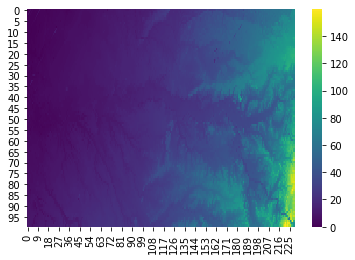

In [396]:
# np.savetxt(gwfm_dir+'\DIS_data\dem_44_7_200m_nearest.tsv', dem_data, delimiter = '\t')

# Based on Maribeth's grid aligned with Alisha's TPROGS model
# dem_data = np.loadtxt(gwfm_dir+'\DIS_data\dem_52_9_200m_nearest.tsv', delimiter = '\t')
dem_data = np.loadtxt(gwfm_dir+'\DIS_data\dem_52_9_200m_linear.tsv', delimiter = '\t')
# dem_data = np.loadtxt(gwfm_dir+'\DIS_data\dem_44_7_200m_linear_missing_right_corner.tsv', delimiter = '\t')

# dem_data = np.loadtxt(gwfm_dir+'\DIS_data\dem_44_7_200m_nearest.tsv', delimiter = '\t')

import seaborn as sns
sns.heatmap(dem_data, cmap = 'viridis', vmin = 0)

## Import soil data for Lake Package, UZF Package, SFR Package hydraulic parameters

In [408]:
mb_name = gwfm_dir+"/NewModelDomain/GWModelDomain_52_9deg_UTM10N_WGS84.shp"

mb = gpd.read_file(mb_name)
mb = mb.to_crs('epsg:32610')

In [409]:
uzf_path = gwfm_dir+'\\UZF_data'
soil_path = uzf_path+'\\wss_gsmsoil_CA'
# # Read in the soil map spatial data
# soil_gpd = gpd.read_file(uzf_path+'\\wss_gsmsoil_CA\\spatial\\gsmsoilmu_a_ca.shp')
# soil_gpd = soil_gpd.to_crs('EPSG:32610')
# # soil_gpd.plot()

### Write grid_uzf to shapefile to avoid having to repeat analysis

In [416]:
# grid_uzf.to_file(uzf_path+'/final_grid_uzf/griduzf.shp')
grid_uzf = gpd.read_file(uzf_path+'/final_grid_uzf/griduzf.shp')

In [417]:
def fill_uzf(uzfvalues, grid_uzf):
    # convert geopandas object to regular np array for soil data
    temp = np.zeros((nrow,ncol))
    temp[(grid_uzf.row.values-1).astype(int),(grid_uzf.column.values-1).astype(int)] = uzfvalues
    return(temp)

In [418]:
soilKs_array = np.loadtxt(uzf_path+'/final_soilKs.tsv', delimiter = '\t')
soiln_array = np.loadtxt(uzf_path+'/final_soiln.tsv', delimiter = '\t')
soileps_array = np.loadtxt(uzf_path+'/final_soileps.tsv', delimiter = '\t')

# soilKs_array = fill_uzf(grid_uzf.Ksat_Rep, grid_uzf)
# soiln_array = fill_uzf(grid_uzf.Porosity_R, grid_uzf)
# soileps_array = fill_uzf(grid_uzf.EPS, grid_uzf)

# np.savetxt(uzf_path+'/final_soilKs.tsv', soilKs_array, delimiter = '\t')
# np.savetxt(uzf_path+'/final_soiln.tsv', soiln_array, delimiter = '\t')
# np.savetxt(uzf_path+'/final_soileps.tsv', soileps_array, delimiter = '\t')

# SFR

In [423]:
sfr_dir = gwfm_dir+'/SFR_data/'

In [424]:
mb_name = gwfm_dir+"/NewModelDomain/GWModelDomain_52_9deg_UTM10N_WGS84.shp"
# mb_name = gwfm_dir+"/GWModelDomain_UTM10N/GWModelDomain_Rec_UTM10N.shp"

# Rivers and creeks in the larger area encompassing Cosumnes River in both South American and Cosumnes Subbasins
rivers = gpd.read_file(gwfm_dir+"/SFR_data/Sac_valley_rivers/Sac_valley_rivers.shp")
mb = gpd.read_file(mb_name)
mb = mb.to_crs('epsg:32610')
rivers = rivers.to_crs('EPSG:32610')
rivers_clip = gpd.clip(rivers, mb)
rivers_clip.plot()
# rivers_clip.GNIS_Name.unique()

In [425]:
print(rivers_clip.columns)
# Split into individual streams/creeks
cr_ind = rivers_clip[rivers_clip.GNIS_Name == 'Cosumnes River']
dc_ind = rivers_clip[rivers_clip.GNIS_Name == 'Deer Creek']
cc_ind = rivers_clip[rivers_clip.GNIS_Name ==  'Coyote Creek']
# Pull out data for each river/creek
cr = rivers_clip.loc[cr_ind.index,]
dc = rivers_clip.loc[dc_ind.index,]
cc = rivers_clip.loc[cc_ind.index,]


In [426]:
import fiona
from shapely.geometry import shape, mapping
from shapely.ops import linemerge

cr.geometry.values.crs = "epsg:32610"
geom = linemerge(cr.geometry.values)
# how often to interpolate a point
dline = 10
# # length of the LineString
length = int(geom.length)
point = np.zeros((int(length/dline)+1,3))
for i, distance in enumerate(range(0, int(length), dline)):
         point[i,:] = geom.interpolate(distance).coords[:][0]
point = point[:,[0,1]]
plt.plot(point[:,0],point[:,1])


In [427]:
raster_name = gwfm_dir+'/DEM_data/USGS_ten_meter_dem/regional_10m.tif'

# dem10 = rasterio.open(raster_name)

pnts = pd.DataFrame()
with rasterio.open(raster_name) as src:
    pnts['z'] = [sample[0] for sample in src.sample(point)]
pnts
pnts['easting'] = point[:,0]
pnts['northing'] = point[:,1]
pnts = pnts[pnts.z > -1E4]



In [428]:
plt.figure(figsize = (10,10))
pnts.z.plot()
pnts['slope'] = 0.002
for i in np.arange(1,len(pnts)):
    if pnts.z.values[i] >= pnts.z.values[i-1]:
        # if strtop is greater than previous strtop use previous elevation minus the average slope
        slope = ((np.max(pnts.z) - np.min(pnts.z))/geom.length)*dline
        if pnts.index[i] < 800:
            slope = 0.002
        elif pnts.index[i] < 2700:
            slope = 0.0003
        elif pnts.index[i] < 3200:
            slope = 0.001
        else:
            slope = 0.0003
        pnts.z.values[i] = pnts.z.values[i-1] - slope*dline
        pnts.slope.values[i] = slope
pnts.z.plot()

In [429]:
 pnts['Point_order'] = pnts.index

In [430]:
pnts_gpd = gpd.GeoDataFrame(pnts, geometry = gpd.points_from_xy(pnts.easting, pnts.northing))
pnts_gpd.crs = 'epsg:32610'

In [432]:
# # Samples the points every 10 meters to match with the 100 meter grid
grid_sfr = gpd.sjoin(grid_p, pnts_gpd, how = "inner", op= "intersects")
grid_sfr.plot()

In [433]:
# # Set reach length for each reach based on the separation used to create the points from the line object
# # dline is 10 meters
grid_sfr['length_m'] = dline

# Dissolve the points again but using sum this time to get the total length of each reach
temp = grid_sfr.dissolve(by = 'node', aggfunc = 'sum').length_m.values

# Dissolves the points every 10 meters to the 200 meter spacing, using mean because the interested component is elevation
grid_sfr = grid_sfr.dissolve(by = 'node', aggfunc = 'mean')
grid_sfr.length_m = temp

grid_sfr = grid_sfr.sort_values(by = 'Point_order')
grid_sfr['reach'] = np.arange(1,len(grid_sfr)+1)

In [434]:
# grid_sfr.to_file(sfr_dir+'/final_grid_sfr/grid_sfr.shp')
# grid_sfr = gpd.read_file(sfr_dir+'/final_grid_sfr/grid_sfr.shp')


In [435]:
# floodplain sensor info
fp_sensors = gpd.read_file(gwfm_dir+"/LAK_data/floodplain_logger_metadata.csv", header = True)
fp_sensors.Northing = fp_sensors.Northing.astype(np.float64)
fp_sensors.Easting = fp_sensors.Easting.astype(np.float64)
fp_sensors.geometry = gpd.points_from_xy(fp_sensors.Easting, fp_sensors.Northing)
fp_sensors.crs = 'epsg:32610'

In [436]:
# od_breach is the sensor location where the breach was made in the levees for flow to leave the river
od_breach = fp_sensors[fp_sensors['Logger Location']=='OD_Excavation']
od_breach


,Logger Location,Logger Type,Easting,Northing,Elevation,Solinst Logger Serial Number 2012,Solinst Logger Serial Number 2013,Solinst Logger Serial Number 2014,Solinst Logger Serial Number 2015,Solinst Logger Serial Number 2016,geometry
2,OD_Excavation,Breach,641763.495,4241361.24,6.597,,,,32037867,21052169,POINT (641763.495 4241361.240)


In [437]:
# first need to try with just adding extra cross section
# append the extra reach to the list of reaches and resort by reach
# grid_sfr = grid_sfr.append(grid_breach).sort_values(by = 'reach')
# # next, need to relabel reaches to account for the added reach witha duplicate number
# grid_sfr.reach = np.arange(1,len(grid_sfr)+1)
# grid_sfr

In [438]:
# # Buffer the location of the breach sensor to have overlap with the river streamline
# just sjoin the geometry because the extra info is unnecessary
# spatial join breach sensor polygon with sfr grid locations to find match
grid_breach = gpd.sjoin(grid_sfr, 
                        gpd.GeoDataFrame(geometry = od_breach.geometry.buffer(25), crs = 'epsg:32610'), how = "inner", op= "intersects")
# add a reach to the overlap cell that will be used to divert flow (there will be two reaches in one cell)
grid_breach

,node,row,column,index_righ,z,easting,northing,slope,Point_orde,length_m,reach,geometry,index_right
292,10164,45.0,44.0,4994.0,6.838629,641880.440454,4.241351e+06,0.0003,4994.0,210,293,"POLYGON ((641754.648 4241315.151, 641875.290 4...",2


In [439]:
XS8pt = pd.read_csv(sfr_dir+'8pointXS.csv')
XSlocs = gpd.read_file(sfr_dir+'8pointXS_locs\\8pointXS_locs.shp')
XSlocs.crs = 32610

XSg  = gpd.sjoin(grid_sfr, XSlocs, how = "inner", op= "contains", lsuffix = 'sfr',rsuffix = 'xs')
# Append the grid_breach location to the list of cross sections to split the segment
XSg = XSg.append(grid_breach).sort_values('reach')
# Copy the XS site name from the previous last site to the breach site to keep same XS
XSg.Site.iloc[-1] = XSg.Site.iloc[-2]
len(XSg), len(XS8pt.loc[0,:])/2

C:\Users\ajcalder\anaconda3\envs\geosp\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


(29, 30.0)

### Read in 8 pt XS, revised by simplifying from Constantine 2001

In [440]:
# There is one reach for each cell that a river crosses
NSTRM = -len(grid_sfr)
# There should a be a stream segment if there are major changes
# in variables in Item 4 or Item 6
# 1st segment is for the usgs Michigan Bar rating curve, one for each XS, plus 2 for the floodplain diversion
NSS = 1 + len(XSg) 
# nparseg (int) number of stream-segment definition with all parameters, must be zero when nstrm is negative
NPARSEG = 0
CONST = 86400 # mannings constant for SI units, 1.0 for seconds, 86400 for days
# real value equal to the tolerance of stream depth used in
# computing leakage between each stream reach and active model cell
DLEAK = 0.0001 # unit in lengths, 0.0001 is sufficient for units of meters
IPAKCB = 55
# writes out stream depth, width, conductance, gradient when cell by cell
# budget is specified and istcb2 is the unit folder
ISTCB2 = 54
# specifies whether unsat flow beneath stream or not, isfropt 2 has properties read for each reach, isfropt 3 also has UHC
# read for each reach, isfropt 4 has properties read for each segment (no UHC), 5 reads for each segment with UHC
ISFROPT = 1
# nstrail (int), number of trailing weave increments used to represent a trailing wave, used to represent a decrease 
# in the surface infiltration rate. Can be increased to improve mass balance, values between 10-20 work well with error 
# beneath streams ranging between 0.001 and 0.01 percent, default is 10 (only when isfropt >1)
NSTRAIL = 20
# isuzn (int) tells max number of vertical cells used to define the unsaturated zone beneath a stream reach (default is 1)
ISUZN = 1
#nsfrsets (int) is max number of different sets of trailing waves (used to allocate arrays), a value of 30 is sufficient for problems
# where stream depth varies often, value doesn't effect run time (default is 30)
NSFRSETS = 30
# IRTFLG (int) indicates whether transient streamflow routing is active, must be specified if NSTRM <0. If IRTFLG >0 then
# flow will be routed with the kinematic-wave equations, otherwise it should be 0 (only for MF2005), default is 1
IRTFLG = 1
# numtim (int) is number of sub time steps used to route streamflow. Streamflow time step = MF Time step / NUMTIM. 
# Default is 2, only when IRTFLG >0
NUMTIM = 4
# weight (float) is a weighting factor used to calculate change in channel storage 0.5 - 1 (default of 0.75) 
WEIGHT = 0.75
# flwtol (float), flow tolerance, a value of 0.00003 m3/s has been used successfully (default of 0.0001)
FLWTOL = 0.0001

sfr = flopy.modflow.ModflowSfr2(model = m, nstrm = NSTRM, nss = NSS, nparseg = NPARSEG, 
                           const = CONST, dleak = DLEAK, ipakcb = IPAKCB, istcb2 = ISTCB2, 
                          isfropt = ISFROPT, nstrail = NSTRAIL, isuzn = ISUZN, irtflg = IRTFLG, 
                          numtim = NUMTIM, weight = WEIGHT, flwtol = FLWTOL,
                                reachinput=True, transroute=True, tabfiles=True,
                                tabfiles_dict={1: {'numval': nper, 'inuit': 56}})

In [441]:
# Add option block at the top of the sfr input file for tabfiles
tab_option = flopy.utils.OptionBlock(options_line = ' reachinput transroute tabfiles 1 ' + str(nper), package = sfr, block = True)
sfr.options = tab_option
# sfr.options

In [442]:
# Modflow NWT additions to SFR package set up
# sfr.transroute = True
# sfr.reachinput = True
# sfr.tabfiles = True
# # numval is the number of values in the flow tab files, inuit is the corresponding unit file
# sfr.tabfiles_dict = {1: {'numval': nper, 'inuit': 56}}

In [443]:
xs_sfr = grid_sfr.set_index('reach')
# set all reaches to start as segment 1 which will be changed iteratively based on the number of cross-sections
xs_sfr['iseg'] = 1
# add a column reach_new that will be changed iteratively as the segment number is changed
xs_sfr['reach_new'] = xs_sfr.index
# xs_sfr

## Define reach data based on ISFROPT

In [444]:
## Given the reach number of each XS, the 718 reaches will be broken down into each segment
## create a new reach column based on XS reach number and 

segcount = 2
for i in np.arange(0,len(XSg)):
    temp_reach = XSg.reach.values[i]
    rchnum = xs_sfr.index[-1] - temp_reach+1
    xs_sfr.reach_new.loc[temp_reach:] = np.linspace(1,rchnum, rchnum)
    xs_sfr.iseg.loc[temp_reach:] = segcount
    segcount +=1

In [445]:
xs_sfr.reach_new = xs_sfr.reach_new.astype(int)


In [446]:
# Determine which layer the streamcell is in
# since the if statement only checks whether the first layer is greater than the streambed elevation, 
# otherwise it would be less than and zero (most should be in layer 0)
sfr_lay = np.zeros(len(grid_sfr))

for i in np.arange(0,nlay-1):
    # pull out elevation of layer bottom
    lay_elev = botm[i, (grid_sfr.row.values-1).astype(int), (grid_sfr.column.values-1).astype(int)]
    for j in np.arange(0,len(grid_sfr)):
        # want to compare if streambed is lower than the layer bottom
        # 1 will be subtracted from each z value to make sure it is lower than the model top in the upper reaches
        if lay_elev[j] < (grid_sfr.z.values-1)[j]:
            sfr_lay[j] = i 
        


In [447]:
# KRCH, IRCH, JRCH, ISEG, IREACH, RCHLEN, STRTOP, SLOPE, STRTHICK, STRHC1, THTS, THTI, EPS, UHC

columns = ['KRCH', 'IRCH', 'JRCH', 'ISEG', 'IREACH', 'RCHLEN', 'STRTOP', 
               'SLOPE', 'STRTHICK', 'STRHC1', 'THTS', 'THTI', 'EPS', 'UHC']

sfr.reach_data.node = grid_sfr.index
sfr.reach_data.k = sfr_lay.astype(int)
sfr.reach_data.i = grid_sfr.row.values-1
sfr.reach_data.j = grid_sfr.column.values-1
sfr.reach_data.iseg = xs_sfr.iseg
sfr.reach_data.ireach = xs_sfr.reach_new
sfr.reach_data.rchlen = xs_sfr.length_m.values
sfr.reach_data.strtop = grid_sfr.z.values-1
sfr.reach_data.slope = grid_sfr.slope.values
sfr.reach_data.strthick = 2 # guess 2 meters thick streambed
# 0.004125 m/s average which is 356.4266 m/d
sfr.reach_data.strhc1 = soilKs_array[sfr.reach_data.i, sfr.reach_data.j]
sfr.reach_data.thts = soiln_array[sfr.reach_data.i, sfr.reach_data.j]
sfr.reach_data.thti = sfr.reach_data.thts
sfr.reach_data.eps = soileps_array[sfr.reach_data.i, sfr.reach_data.j]


In [448]:
mb4rl = pd.read_csv(sfr_dir+'michigan_bar_icalc4_data.csv', skiprows = 0, sep = ',')
# mb4rl.plot(x='gage_height_va',y='discharge_va', legend = False)
# plt.xlabel('Gage height (m)')
# plt.ylabel('Discharge $(m^3/d$)')
# plt.ticklabel_format(style='scientific') # plain to show all zeros
# plt.title('Simplified USGS Michigan Bar Rating Curve')
# plt.savefig('Plots/Model_SFR_UZF_Progress/MB_ratingcurve', dpi = 300, bbox_inches='tight')

## Define segment data

Median grain size (mm) ranges from 1 mm – 30 mm along surveyed sites, which gives a range of 0.026-0.035 for a stable channel
Moderate channel irregularity due to channel scouring and pools alternating, range of 0.006-0.010
Gradual cross section change: 0.000 adjustment
Effect of obstructions: minor due to occasional downed logs and debris in river, 0.005-0.015
Amount of vegetation: large on banks due to willows and cottonwood trees, 0.025-0.050, and negligible in the channel
Degree of meandering: minor due to levees, m = 1.0

n = (nb+n1+n2+n3+n4)*m (b=base,1=surface irregularity, 2 = XS variation, 3 = obstructions, 4 = vegetation, m = correction for meandering)
n = (0.03+0.08+0.01) = 0.048 in channel
n = (0.048 +0.03) = 0.078 on banks


In [449]:
# There is one dictionary key for each stress period (starting at 0) and in each dictionary key there is a 
# rec array holding an entry for each stream segment where nseg shows which segment it is (ie no dictionary key for segment)
# If ITMP = 0 Item 4 is used, if ITMP >0 Item 6 is used, 
# if ITMP <0 the stream segment data not defined in Item 4 will be reused form the last stress period
nss = NSS
if sfr.dataset_5[0][0] > 0 :
    # For the first stress period
    t = 0
    for i in np.arange(0, nss):
        # Section 6a
        sfr.segment_data[t][i].nseg = int(i)+1
        if sfr.segment_data[t][i].nseg ==1:
            sfr.segment_data[t][i].icalc = 4
        else:
            sfr.segment_data[t][i].icalc = 2 # Mannings and 8 point channel XS is 2 with plain MF, 5 with SAFE
        if sfr.segment_data[t][i].nseg != nss:
            sfr.segment_data[t][i].outseg =sfr.segment_data[t][i].nseg +1
        elif sfr.segment_data[t][i].nseg == nss:
            sfr.segment_data[t][i].outseg = 0
        if sfr.segment_data[t][i].nseg != 1:
            sfr.segment_data[t][i].iupseg =sfr.segment_data[t][i].nseg - 1
            # Integer value that defines priority for diversion
            sfr.segment_data[t][i].iprior = -2 #diversion made will max out at flow in channel leaving no flow in channel
        elif sfr.segment_data[t][i].nseg ==1:
            sfr.segment_data[t][i].iupseg = 0
        if sfr.segment_data[t][i].icalc ==4:
            sfr.segment_data[t][i].nstrpts = len(mb4rl)
        # Defined 
        if sfr.segment_data[t][i].nseg != 1:
            sfr.segment_data[t][i].flow= 1
        elif sfr.segment_data[t][i].nseg ==1:
            sfr.segment_data[t][i].flow= 2.834*86400. # m3/day, originally 15 m3/s
        sfr.segment_data[t][i].runoff = 0.0
        sfr.segment_data[t][i].etsw = 0.01
        sfr.segment_data[t][i].pptsw = 0.01
        # Manning's n data comes from Barnes 1967 UGSS Paper 1849 and USGS 1989 report on selecting manning's n
        # RoughCH is only specified for icalc = 1 or 2
        if sfr.segment_data[t][i].icalc == 1 or sfr.segment_data[t][i].icalc ==2:
            sfr.segment_data[t][i].roughch = 0.048
        # ROUGHBK is only specified for icalc = 2
        if sfr.segment_data[t][i].icalc == 2 or sfr.segment_data[t][i].icalc == 5:
            sfr.segment_data[t][i].roughbk = 0.083 # higher due to vegetation
            
            
# Define stress period data need one for each stress period
# Dataset 5 will be built automatically from segment_data unless specified
# ITMP (int) for reusing or reading stream seg data that can change each stress period
#IRDFLG, 0 is input data printed, greater than 0 input data is not printed
# doesn't seem to change the value
# IPTFLG, 0 is streamflow-routing results printed, greater than 0 not

In [450]:
# Pull out data for upstream and downstream reach of each segment
up_data = xs_sfr.drop_duplicates('iseg')
dn_data = xs_sfr.sort_values('reach_new',ascending = False).drop_duplicates('iseg').sort_values('iseg')


# Need to return to later and remove hard coding
# These are getting used for initial guesses
# Read in first stress period when ICALC = 1 or 2 and ISFROPT is 5
# Dataset 6b
sfr.segment_data[0].hcond1 = sfr.reach_data.strhc1[0]
sfr.segment_data[0].thickm1 = 2
sfr.segment_data[0].elevup = up_data.z.values
sfr.segment_data[0].width1 = 20
sfr.segment_data[0].depth1 = 1
sfr.segment_data[0].thts1 = 0.4
sfr.segment_data[0].thti1 = 0.15
sfr.segment_data[0].eps1 = 4
sfr.segment_data[0].uhc1 = sfr.reach_data.strhc1[0]

# Dataset 6c
sfr.segment_data[0].hcond2 = sfr.reach_data.strhc1[-1]
sfr.segment_data[0].thickm2 = 2
sfr.segment_data[0].elevdn = dn_data.z.values
sfr.segment_data[0].width2 = 20
sfr.segment_data[0].depth2 = 1
sfr.segment_data[0].thts2 = 0.4
sfr.segment_data[0].thti2 = 0.15
sfr.segment_data[0].eps2 = 4
sfr.segment_data[0].uhc2 = sfr.reach_data.strhc1[-1]


In [451]:
# Change column name to float type for easier referencing in iteration
XS8pt.columns = XS8pt.columns.astype('float')
# Pre-create dictionary to be filled in loop
sfr.channel_geometry_data = {0:{j:[] for j in np.arange(2,len(XSg)+2)}  }

xsnum = 2
for k in XSg.Site.values:
        pos = int(XS8pt.columns.get_loc(k))
        XCPT = XS8pt.iloc[:,pos].values
        ZCPT = XS8pt.iloc[:,pos+1].values
        ZCPT_min = np.min(ZCPT)
        ZCPT-= ZCPT_min
        sfr.channel_geometry_data[0][xsnum] = [XCPT, ZCPT]
        xsnum += 1


In [452]:
FLOWTAB = mb4rl.discharge_va.values
DPTHTAB = mb4rl.gage_height_va.values
WDTHTAB = mb4rl.chan_width.values
sfr.channel_flow_data = {0: {1: [FLOWTAB, DPTHTAB, WDTHTAB]}}

In [453]:
# sfr.plot_path(start_seg=1, end_seg=0, plot_segment_lines=True)
# plt.savefig('Plots/Model_SFR_UZF_Progress/sfr_elev_vs_model_top.png', dpi = 600, bbox_inches='tight')

## Complex ibound

### Define no flow cells based on elevation, informed by DWR cross sections and geologic maps of volcanic geology fingers leaving the mountains
In general, the location of Michigan Bar is near the boundary where there is total volcanics to majority alluvium. However there is a major finger North and South of the Cosumnes River of andesititc conglomerate, sandstone, breccia

In [454]:
# Simplified ibound, only no flow cell if it is below the bottom of the Mehrten Formation
# Specify no flow boundary based on rough approx of geology (upper basin volcanics)
# ibound = np.ones([nlay, nrow,ncol])
strt = np.ones((nlay, nrow, ncol), dtype = np.float32)
# The model should start in hydraulic connection
strt[:,:,:] = np.mean(m.dis.top[:,:], axis = 0)
# strt[:,:,:] = m.dis.top[:,:]

# # no_flow_bound[0,:]
# for k in np.arange(0,nlay):
#     for j in np.arange(0,ncol):
#         for i in np.arange(0,nrow):
#             # Check whether the bottom elevation is actual below where there shouldn't be flow
#             if botm[k,i,j] < no_flow_bound[i,j]:
#                 ibound[k,i,j] = 0


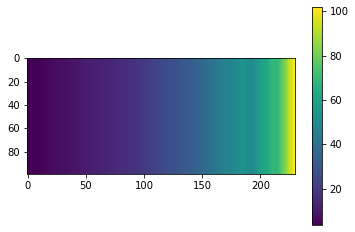

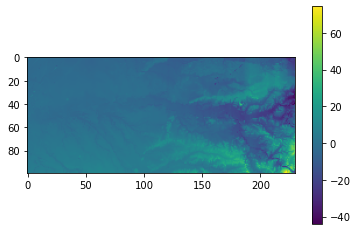

In [455]:
plt.imshow(strt[0,:,:])
plt.colorbar()
plt.show()
plt.imshow(dem_data-strt[0,:,:])
plt.colorbar()
plt.show()

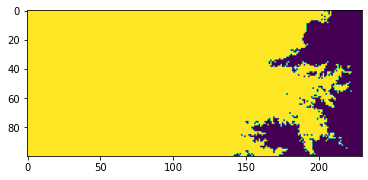

In [456]:
ibound = np.ones([nlay, nrow,ncol])
strt = np.ones((nlay, nrow, ncol), dtype = np.float32)
# The model should start in hydraulic connection
strt[:,:,:] = np.mean(m.dis.top[:,:], axis = 0)

cutoff_elev = 56
ibound = ibound*(dem_data<cutoff_elev)

chd_locs = np.where(((dem_data<cutoff_elev)&(dem_data>cutoff_elev*0.985)))

plt.imshow(ibound[0,:,:])

In [457]:
# the heads at the constant head cells should be at or below the ground surface
strt[0,chd_locs[0],chd_locs[1]] = dem_data[chd_locs[0],chd_locs[1]]-10

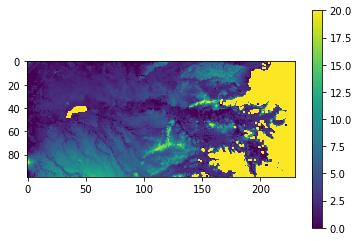

In [458]:
strt_heads_sp6 = np.loadtxt('model_heads_after_sp6_use_for_strt_heads.tsv', delimiter = '\t')
# strt[:,:,:] = strt_heads_sp6
plt.imshow(dem_data- strt_heads_sp6, vmin = 0, vmax = 20)
plt.colorbar()

### Create a line bounding the noflow region to set the specified head boundary

In [459]:
import pprint
from rasterio.features import shapes, rasterize

# The function shapes from rasterio requires uint8 format
ibound_line = ibound.astype(rasterio.uint8)
out = shapes(ibound_line,connectivity = 8)
alldata = list(out)

# maxl = 0
maxl = np.zeros(len(alldata))
for i in np.arange(0,len(alldata)):
    maxl[i] = len(alldata[i][0].get('coordinates')[0])
#     if len(alldata[i][0].get('coordinates')[0])>maxl:
#         maxl = len(alldata[i][0].get('coordinates')[0])
#         ind = i
# select the two longest linestring indexes (1st will be chunk down of divide (lower elevation) 2nd will chunk above (high elev))
maxl1, maxl2 = np.where(maxl>np.mean(maxl))[0]
print(maxl[maxl>np.mean(maxl)])

[647. 607.]


In [460]:
temp = alldata[maxl2][0].get('coordinates')[0]
tl = LineString(temp)
tl

In [461]:
from shapely.ops import LineString, linemerge, polygonize, unary_union
tl = LineString(temp)

# Get the constant head or general head boundary after the no flow cells
linerast = rasterio.features.rasterize([tl], out_shape = np.array((nrow,ncol)))
# remove far east bound line
linerast[:,ncol-1] = 0
fix_bound = np.min(np.argwhere(linerast[0,:]==1))
linerast[0,:] = 0
linerast[0,fix_bound]
np.shape(linerast)

# ibound[0,linerast==1] = -1

(100, 230)

In [462]:
from shapely.ops import LineString, linemerge, polygonize, unary_union
tl = LineString(temp)
tu = unary_union(tl)
poly = list(polygonize(tu))
# Set the polygon/raster for the top layer, no buffer needed
poly0 = poly[0].buffer(distance = 0)
polyrast0 = rasterio.features.rasterize([poly0], out_shape = np.array((nrow,ncol)))
# Set the polygon/raster for the top layer, slight buffer needed to expand geologic formation outward with depth as 
# naturally occurs
poly1 = poly[0].buffer(distance = 13)
polyrast1 = rasterio.features.rasterize([poly1], out_shape = np.array((nrow,ncol)))
# Set the polygon/raster for the bottom layer, largest buffer needed
poly2 = poly[0].buffer(distance = 17)
polyrast2 = rasterio.features.rasterize([poly2], out_shape = np.array((nrow,ncol)))

ibound = np.ones([nlay, nrow,ncol])
# Need to decide whether all layers or just the top layer are affected by ibound from elevation
# it is better to define the top layer with a simple dem>elevation check than the rasterize functins that isn't perfect
# ibound[0,polyrast0==1] = 0
# Need to decide whether all layers or just the top layer are affected by ibound from elevation
ibound[-2,polyrast1==1] = 0
# Need to decide whether all layers or just the top layer are affected by ibound from elevation
ibound[-1,polyrast2==1] = 0

# The bottom boundary has a dip of 1-2 degrees which is essentially a slope of 0.015 based on given cross section data
# The layer thickness for TPROGS
laythk = tprog_thick
# It appeared shapely buffer is on the scale of kilometers
run = (laythk/0.015)/1000
run_const = run
for i in np.arange(1,nlay-2):
    # error saying poly[i] is not subscriptable
    polyi = poly[0].buffer(distance = run)
    polyrast = rasterio.features.rasterize([polyi], out_shape = np.array((nrow,ncol)))
    # Need to decide whether all layers or just the top layer are affected by ibound from elevation
    ibound[i,polyrast==1] = 0
    run += run_const

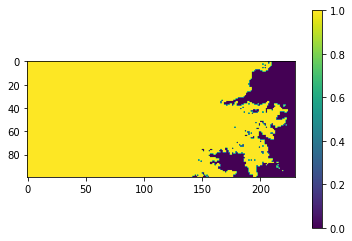

In [463]:
# wherever the constant head/specified head bound is the cells need to be active
ibound[0,dem_data>cutoff_elev] = 0
ibound[0,linerast==1] = 1
plt.imshow(ibound[0,:,:])
plt.colorbar()

In [464]:
# copy the ibound array to alter the geology array to set these cells as low permeability formations
# either marine or volcanic based
deep_geology = ibound[:,:,:]

# reset ibound to all active cells to reduce non-linearity
# still need to take account of no flow cells for lake package
# ibound = np.ones([nlay, nrow,ncol])

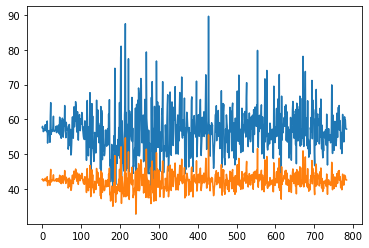

In [465]:
# plt.plot(dem_data[:,end_no_flow])

# plt.plot((dem_data[:,end_no_flow]+np.min(dis.top.array[:,end_no_flow]))/2)
# plt.plot([0,80],[np.mean(dis.top.array[:,end_no_flow])]*2)
# plt.plot([0,80],[np.min(dis.top.array[:,end_no_flow])]*2)

head = dem_data[linerast==1]
# head = dem_data[:,mean_col]
plt.plot(head)
headmin = np.min(dem_data[linerast==1])
ch_weight = 0.6
head = head*(1-ch_weight)+headmin*ch_weight
plt.plot(head)
plt.plot(headmin)


### Remove no flow cells in the first layer where there are stream cells

In [466]:
# Get indices of SFR cells
sfr_x = grid_sfr.row.values.astype(int)-1
sfr_y = grid_sfr.column.values.astype(int)-1
# Check where SFR cells overlap the no flow cell array 
overlap = ibound[0, sfr_x, sfr_y]==0
# Convert the cells that overlap from inactive to active cells
ibound[0,sfr_x[overlap], sfr_y[overlap]] = 1
# Check where SFR cells overlap the constant head cell array 
overlap = ibound[0, sfr_x, sfr_y]==-1
# Convert the cells that overlap from inactive to active cells
ibound[0,sfr_x[overlap], sfr_y[overlap]] = 1

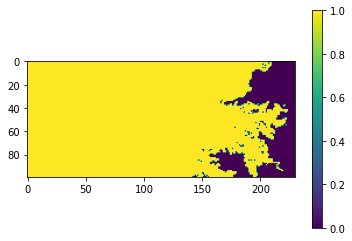

In [467]:
plt.imshow(ibound[0,:,:])
plt.colorbar()

In [468]:
lak_inactive = (lakarr[0,:,:]-1)*-1
# Make the cells in the first layer that underly the lake inactive
ibound[0,:,:] = lak_inactive*ibound[0,:,:]

In [469]:
# where the specified head boundary is the cells must be active
# ibound[0,chd_locs[0], chd_locs[1]] = -1

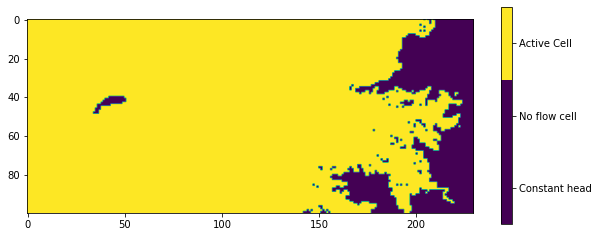

In [470]:
fig, ax = plt.subplots(figsize = (10,10))
plt.imshow(ibound[0,:,:])

cbar = plt.colorbar(shrink = 0.4, ticks = np.arange(-1,2), values = np.arange(-1,2), spacing = 'proportional' )
cbar.ax.set_yticklabels(np.array(('Constant head', 'No flow cell', 'Active Cell'), dtype = 'object' ))
plt.savefig('Plots/Model_SFR_UZF_Progress/Ibound_plot.png', dpi = 300)

In [471]:
# Basic package, BAS

# ibound < 0 is constant head
# ibound = 0 is inactive cell
# ibound > 0 is active cell
# strt is array of starting heads
bas = flopy.modflow.ModflowBas(model = m, ibound=ibound, strt = strt)

In [472]:
bas.check()



BAS6 PACKAGE DATA VALIDATION:
  3 Warnings:
    3 instances of isolated cells in ibound array

  Checks that passed:
    Not a number



"When subsurface recharge (MBR2) is negligible,
stream runoff at the mountain front (runoff measured at
point B in Figure 1, or RO) may be considered the total
contribution to MFR [Anderholm, 2000]." (Wilson and Guan 2004)

## Read in TPROGS data

In [478]:
import scipy.io
upw_dir = gwfm_dir + '/UPW_data'
tprogs_dir = upw_dir + '/TPROGS_upscale_50_mat'
# Units of K are m/d for both
khmat = scipy.io.loadmat(tprogs_dir + '\\K_xy_Upscale_50')['Upscale_50']
kvmat = scipy.io.loadmat(tprogs_dir + '\\Kz_Upscale_50')['Upscale_50']
ssmat = scipy.io.loadmat(tprogs_dir + '\\Ss_Upscale_50')['Upscale_50']
symat = scipy.io.loadmat(tprogs_dir + '\\Sy_Upscale_50')['Upscale_50']
# Column 1 is nodes, number1 is the bottom left hand corner, x,y coords are the 2nd/3rd columns, the 4th columns
# is the elevation of the center coordinate, the 5th is the water table elevation from Steve's model
# CRS is albers 3310
tcoords = pd.read_csv(tprogs_dir+'\\Center_coordinates_for_Andrew_July_2020.csv', 
                      header = None, names = ['Node', 'X','Y','elev','DTW'])
gcoords = gpd.GeoDataFrame(tcoords, geometry = gpd.points_from_xy(tcoords.X, tcoords.Y))
gcoords.crs = 'epsg:3310'
# Switch from Albers crs to UTM Zone 10 with WGS84
gcoords = gcoords.to_crs('epsg:32610')

## Aquifer properties with LPF

In [479]:
from scipy.stats import hmean


# Model homogeneous values for hydraulic properties based on averages from TPROGS
hk = np.mean(khmat)
layvka = 0 # 0 means vka is vert K, not 0 means vka is ratio of horiz to vert K
vka = hmean(hmean(hmean(kvmat)))
sy = np.mean(symat)
ss = np.mean(ssmat)

# LAYTYP MUST BE GREATER THAN ZERO WHEN IUZFOPT IS 2
laytyp = 1 # 0 is confined, >0 convertible, <0 convertible unless the THICKSTRT option is in effect
# Laywet must be 0 if laytyp is confined laywet = [1,1,1,1,1]
#ipakcb = 53 means cell-by-cell budget is saved because it is non zero (default is 53)

upw = flopy.modflow.ModflowUpw(model = m, hk =hk, layvka = layvka, vka = vka, sy=sy, ss=ss,
                               laytyp=laytyp, ipakcb=53)

In [480]:

def tprog2mf(arr, gcoords, lpf_arr):
    # Reshape TPROGS format so it firts in the gcoords dataframe format
    new = np.reshape(arr,[len(gcoords),arr.shape[2]])
    # Put reshaped array into dataframe so it will merge
    new = pd.DataFrame(new)
    # Convert column names to strings so they're no errors when calling them
    new.columns = new.columns.astype(str)
    # Join the TPROGS data and their spatial references
    gcoords_new = gcoords.join(new)
    
# Spatial join the grid and coordinates of TPROGS data because grid intersect is no longer working
    merged = gpd.sjoin(grid_p, gcoords_new, op = 'intersects', how = 'inner')
    
    # there are two layers on the bottom without TPROGS data
    for i in np.arange(0,nlay -2):
        index = i
        index = index.astype(str)
        lpf_arr[i, merged.row.values-1 ,merged.column.values-1] = merged[index].values
        
    # Output the array that will then be set directly in lpf. hk or vka or sy or ss
    return(lpf_arr)


In [481]:
1e-5*86400


0.8640000000000001

The tuff breccia is very dense, hard and low water yielding. It is supposedly responsible for the many "haystack" hills in the eastern part of the county

DWR report has a few final well pumping rates, drawdowns and specific capacities but limited.

Fleckenstein et al. 2006 found the Mehrten had
Kh = 1 to 1.8 x10^-5 m/s
Kv = 1 to 1.8 x10^-7 m/s
Sy = 0.15 to 0.2
Ss = 1e-4 to 1e-3 m^-1

In [482]:

print(upw.hk.array.shape)
def mehrten_hp(upw_array, hp_value):
    temp = upw_array
    temp[-1,:,:] = hp_value
    return(temp)
# convert hydr. cond. from m/s to m/d
upw.hk = mehrten_hp(upw.hk.array, 1e-5*86400)
upw.vka = mehrten_hp(upw.vka.array, 1e-7*86400)
upw.sy = mehrten_hp(upw.sy.array, 0.15)
upw.ss = mehrten_hp(upw.ss.array, 1e-4)


(12, 100, 230)


## Define the volcanic/marine sediment geology as very low permeability

In [487]:
# plt.imshow(-1*deep_geology[0,:,:]+1)
# plt.colorbar()
# convert to boolean values for referencing upw array
deep_geology = deep_geology.astype(bool)
# invert selection so previously set inactive cells will be selected to set deep geology
deep_geology = np.invert(deep_geology)

def deep_geo_hp(upw_array, hp_value, deep_geology):
    temp = upw_array
    temp[deep_geology] = hp_value
    return(temp)

# 1e-7 hydr. cond. is in the range of
# sandstone: 10^-10 to 10^-6 and
upw.hk = deep_geo_hp(upw.hk.array, 1e-6*86400, deep_geology)
upw.vka = deep_geo_hp(upw.vka.array, 1e-7*86400, deep_geology)
upw.sy = deep_geo_hp(upw.sy.array, 0.1, deep_geology)
upw.ss = deep_geo_hp(upw.ss.array, 1e-6, deep_geology)

In [488]:
# upw.hk = tprog2mf(khmat, gcoords, upw.hk.array)
# upw.vka = tprog2mf(kvmat, gcoords, upw.vka.array)
# upw.ss = tprog2mf(ssmat, gcoords, upw.ss.array)
# upw.sy = tprog2mf(symat, gcoords, upw.sy.array)


## General head boundary representing Delta/Sea Level

In [492]:
ghb = flopy.modflow.ModflowGhb(model = m)

## Northwest and Southeast GHB boundaries based on historical WSEL

In [498]:
# raster cropping will be done in outside script so the only part read in will be the final array
ghb_dir = gwfm_dir+'/GHB_data'

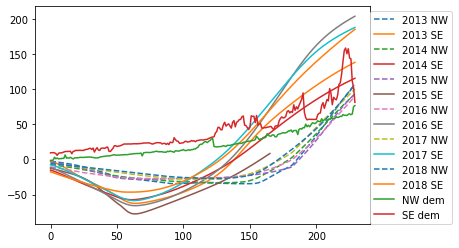

In [499]:
strtyear = 2013
endyear = 2019
kriged_all = np.zeros((int(endyear-strtyear),nrow,ncol))
t=0
for year in np.arange(strtyear,endyear):
    filename = glob.glob(ghb_dir+'/final_WSEL_arrays/fall'+str(year)+'_kriged_WSEL.tsv')[0]
    df_grid = np.loadtxt(filename)
    kriged_all[t,:,:] = df_grid
    t+=1
    # northwest boundary is first row
    NW = df_grid[0,:]
    # southeast boundary is last row
    SE = df_grid[-1,:]
    plt.plot(NW, label = str(year)+' NW', linestyle = '--')
    plt.plot(SE, label = str(year)+' SE')
    # 2018 looks like a pretty average year for water elevations so will use that for now
    if year ==2018:
        nwhead = df_grid[0,:]
        sehead = df_grid[-1,:]
plt.plot(dem_data[0,:],label = 'NW dem')  
plt.plot(dem_data[-1,:],label = 'SE dem')   

plt.legend(loc = [1, 0])
# plt.savefig('Plots/historical_NW_SE_boundary_and_DEM.png',dpi = 600, bbox_inches='tight')
#  need to correct aquifer levels in foothills to be below the dem_data

## Set the starting heads based on historical dwr data

In [500]:
# switch the starting heads from ground surface to match the kriged water surface elevation
# this causes a -5 preconditioning error so didn't actually help
# kriged_strt = np.zeros((nlay,nrow,ncol))
# kriged_strt[:,:,:] = kriged_all[-1,:,:]
# kriged_strt = np.where(kriged_strt>dem_data, dem_data, kriged_strt)
# bas.strt = kriged_strt

In [501]:
# Set kriged water table elevations that are above land surface to land surface
nwhead = np.where(nwhead>dem_data[0,:], dem_data[0,:], nwhead)
sehead = np.where(sehead>dem_data[0,:], dem_data[0,:], sehead)


In [502]:
# Determine which layer the specified head cell is in
# since the if statement only checks whether the first layer is greater than the streambed elevation, 
# otherwise it would be less than and zero (most should be in layer 0)
nw_lay = np.zeros(ncol)
se_lay = np.zeros(ncol)


for k in np.arange(0,nlay-1):
    # pull out elevation of layer bottom
    lay_elevnw = botm[k, 0, :]
    lay_elevse = botm[k, -1, :]
    for j in np.arange(0,ncol):
        if lay_elevnw[j] > nwhead[j]:
            nw_lay[j] = k+2
        if lay_elevse[j] > sehead[j]:
            se_lay[j] = k+2
# correct from float to integer for cell referencing
nw_lay = nw_lay.astype(int)
se_lay = se_lay.astype(int)

In [503]:
# package: lay, row, col, stage, cond
# the northwest boundary is in the first row (0) and the southeast boundary is in the last row (nrow, -1)
# number of layers to go below the first active GHB cell

ghbnw_spd = np.zeros((np.sum(nlay-nw_lay),5))
ghbse_spd = np.zeros((np.sum(nlay-se_lay),5))
p1 = 0
p2=0
distance = 1000
for j in np.arange(0,ncol):
    
    # iterate through northwest layers first to avoid setting dry cells
#     if nw_lay[j]+nlay_senw >nlay:
#         endlay = nlay
#     else:
#         endlay = nw_lay[j]+nlay_senw
    for k in np.arange(nw_lay[j], nlay):
        if k == 0:
            condnw = upw.hk.array[k,int(nrow-1),j]*(dis.top.array[0,j]-dis.botm.array[k,0,j])*delr/distance
        else:
            condnw = upw.hk.array[k,int(nrow-1),j]*(dis.botm.array[k-1, 0,j]-dis.botm.array[k,0,j])*delr/distance
        # take off 0.1 meter in head for each layer drop to support a slight vertical gradient
        ghbnw_spd[p1] = [k, 0, j, nwhead[j]-k*0.1, condnw]
        p1+=1
#     if se_lay[j]+nlay_senw >nlay:
#         endlay = nlay
#     else:
#         endlay = se_lay[j]+nlay_senw
    # iterate through southeast layers to avoid setting dry cells
    for k in np.arange(se_lay[j], nlay):
        if k == 0:
            condse = upw.hk.array[k,int(nrow-1),j]*(dis.top.array[-1,j]-dis.botm.array[k,-1,j])*delr/distance
        else:
            condse = upw.hk.array[k,int(nrow-1),j]*(dis.botm.array[k-1, -1,j]-dis.botm.array[k,-1,j])*delr/distance
        # take off 0.1 meter in head for each layer drop to support a slight vertical gradient
        ghbse_spd[p2] = [k, nrow-1, j, sehead[j]-k*0.1, condse]
        p2+=1
print('Number of GHB cells for NW and SE bound', p1+p2)

Number of GHB cells for NW and SE bound 3740


## Southwest GHB boundary (specified head for outflow to the Delta)

How much would the expected head gradient be near the delta, how fast would head decrease with depth.
Perhaps it would only go down a few meters for every layer

In [504]:
# model north east boundary to replace constant head
# package: lay, row, col, stage, cond

ghbdn_spd = np.zeros((nlay*nrow,5))
# Fine sand	2×10-7 to 2×10-4 m/s
# Silt, loess	1×10-9 to 2×10-5 m/s
# delta soils have some sand mixed in
delta_hk = 1e-5*86400*30

p = 0
distance = 5000
for i in np.arange(0,nrow):
    for k in np.arange(0,nlay):
        if k == 0:
#             cond = upw.hk.array[k,i,0]*(dis.top.array[i,1]-dis.botm.array[k,i,1])*delc/distance
            cond = delta_hk*(dis.top.array[i,1]-dis.botm.array[k,i,1])*delc/distance
        else:
#             cond = upw.hk.array[k,i,0]*(dis.botm.array[k-1, i,1]-dis.botm.array[k,i,1])*delc/distance
            cond = delta_hk*(dis.botm.array[k-1, i,1]-dis.botm.array[k,i,1])*delc/distance
        # take off 0.1 meter in head for each layer drop to support a slight vertical gradient
        ghbdn_spd[p] = [k, i, 0, 0-k*0.1, cond]
        p+=1
print('Number of GHB cells for Delta bound', p)

Number of GHB cells for Delta bound 1200


In [505]:
# lay, row, col for delta ghb
zxy = ghbdn_spd[:,:3].astype(int)
# (botm[zxy[:,0],zxy[:,1],zxy[:,2]]<0).shape
# drop any delta ghb cells where cell bottom is below sea level
ghbdn_spd =  ghbdn_spd[botm[zxy[:,0],zxy[:,1],zxy[:,2]]<0]



In [506]:
# ghb_spd = np.vstack((ghbdn_spd, ghbup_spd))
ghb_spd = np.vstack((ghbdn_spd, ghbse_spd, ghbnw_spd))
# ghb_spd = np.vstack((ghbdn_spd, ghbup_spd, ghbse_spd, ghbnw_spd))


In [507]:
# lay, row, col, head, cond
k = ghb_spd[:,0].astype(int)
i = ghb_spd[:,1].astype(int)
j = ghb_spd[:,2].astype(int)

# find where the ghb overlaps with the no flow cells
active_bc =bas.ibound.array[k,i,j]
# ghb_spd = ghb_spd[active_bc.astype(bool)]

In [508]:
ghb_spd = ghb_spd[:][active_bc.astype(bool)]

In [509]:

# GHB for east and west model boundaries
ghb.stress_period_data =  {0: ghb_spd}
# GHB for only Delta, west side of model
# ghb.stress_period_data =  {0: ghbdn_spd}

In [510]:
ghb.check()


GHB PACKAGE DATA VALIDATION:
  No errors or warnings encountered.

  Checks that passed:
    BC indices valid
    not a number (Nan) entries
    BC in inactive cells
    BC elevation below cell bottom



## CHD Package Time variant head

In [511]:
chd = flopy.modflow.ModflowChd(model=m)

In [512]:
# Determine which layer the specified head cell is in
# since the if statement only checks whether the first layer is greater than the streambed elevation, 
# otherwise it would be less than and zero (most should be in layer 0)
chd_lay = np.zeros(nrow)

head = dem_data[:,ncol-1]
headmin = np.min(head)
ch_weight = 0.9
chd_vals = head*(1-ch_weight)+headmin*ch_weight



for k in np.arange(0,nlay-1):
    # pull out elevation of layer bottom
    lay_elev = botm[k, :, ncol-1]
    for i in np.arange(0,nrow):
        # want to compare if streambed is lower than the layer bottom
        # 1 will be subtracted from each z value to make sure it is lower than the model top in the upper reaches
        if lay_elev[i] > chd_vals[i]:
            chd_lay[i] = k



In [513]:
# layer (int), row (int), column (int), shead (float), ehead (float) shead is the head at the
# start of the stress period, and ehead is the head at the end of the stress period
# nlay_ghb = 1

# constant head boundary for mountain front recharge
# assume that near the mountains the head should be at the surface becaues the aquifer is thin

# new specified head boundary will be linear at the uppermost column to reduce nonlinearity
# as the no flow cells will be removed and replaced with low hydraulic conductivity cells

# chd_spd = np.zeros((len(chd_locs[0]),5))
chd_spd = np.zeros((int(np.sum((nlay-chd_lay))),5))

# # head for mountain front recharge
shead = chd_vals
ehead = chd_vals
p=0
for i in np.arange(0,nrow):
    for k in np.arange(chd_lay[i],nlay):
        chd_spd[p] = [int(k), i, ncol-1, shead[i], ehead[i]]
        p+=1
print('Number of CHD cells for upland bound', p)

Number of CHD cells for upland bound 950


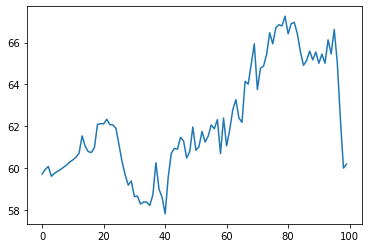

In [514]:
plt.plot(chd_vals)

In [515]:
chd.stress_period_data =  {0: chd_spd}

In [516]:
chd.check()


CHD PACKAGE DATA VALIDATION:
  No errors or warnings encountered.

  Checks that passed:
    BC indices valid
    not a number (Nan) entries
    BC in inactive cells



## Unsaturated Zone

In [511]:
# required to do this method to insure correct formatting and then change parameters in code below, these are 
# mostly default values
uzf = flopy.modflow.ModflowUzf1(model = m,
                                nuztop=3, iuzfopt=2, irunflg=0, ietflg=1,
                                ipakcb=0, # unformatted output file of  ground-water recharge, ET, and ground-water discharge to land surface rates
                                iuzfcb2=61,# binary output of recharge and groundwater discharge
                                ntrail2=25, nsets=20,
                                surfdep=np.mean(np.abs(np.diff(m.dis.top.array, axis = 0))),
                                iuzfbnd=ibound[0,:,:], 
                                finf=0.01, #  temporary value infiltration rates
                                specifythtr = True,
                                thtr = 0.1, # temporary value
                                specifythti = False,
                                eps=3.5, #  temporary value Brooks-Corey relation of water content to hydraulic conductivity (epsilon)
                                thts = 0.35, #  temporary valuesaturated water content of the uz in units of volume of water to total volume
                                pet=5.000000E-08, #  temporary value potential ET
                                extdp=1, #  temporary valueET extinction depth(s)
                                extwc=0.1, #  temporary valueextinction water content below which ET cannot be removed from the unsaturated zone
                                unitnumber=19)

In [512]:
uzf_option = flopy.utils.OptionBlock(options_line = 'specifythtr etsquare', package = uzf, block = True)
uzf.options = uzf_option

### For each simulation

In [513]:
# nuztop define which cell in column that recharge and discharge is simulated
# 1 = recharge/discharge for top model layer only, 2 = rch/dis to layer specified in iuzfbnd
# 3 = rch/dis to highest active cell in each column, top layer is iuzfbnd, const head node prevents deeper perc
uzf.nuztop = 3
# iuzfopt (int) 0 = no unsat zone routing, 1 = kvert specified by UZF in VKS, 2 = kvert taken from LPF or BCF input
uzf.iuzfopt = 2
# irunflg (int), whether gw discharge to land surface will be routed to stream (+1) segments specified by irunbnd or removed
# from the model and accounted as a loss (0)
# start with removed for simplicitly and this would most likely occur on the lower river where it is near model bounds
uzf.irunflg = 0
# ietflg (int) specifies whether ET will be simulated, 0 = no ET, other = ET
# Start with no ET to get simple UZF running
uzf.ietflg = 1
# flag for writing rch, ET, dis to land surface to separate unformatted file
uzf.iuzfcb2 = 0
# nstrail2, number of trailing waves used to define he water content profile following a decrease in the infiltration rate
# range between 10 and 20 is usually adequate
uzf.ntrail2 = 20
# nsets2 (in) number of wave sets used to simulate multiple infiltration periods, should be set to 20 for most problems
uzf.nsets = 20
# nuzgag = num of cells that will be specified for printing detailed information
# uzf.nuzgag = 0
# surfdep = avg undulation depth in the land surface within a finite-difference cell
# average difference between elevation along rows to estimate undulation
uzf.surfdep = np.mean(np.abs(np.diff(m.dis.top.array, axis = 0)))

In [514]:
# areal extent in which UZF will be simulated
iuzfbnd = ibound[0,:,:]
# removes -1 from const head boundary and convert to just active vs inactive cells
iuzfbnd[iuzfbnd[:,:] == -1] = 0
uzf.iuzfbnd = iuzfbnd[:,:]
# if irunflg>0 then specify irunbnd
# array of (int) to define stream segments that overland runoff from excess infil and gw discharge
# to land surface will be added

# uzf.irunbnd = iuzfbnd[:,:]



### For each stress period

The code that originally imported the state soil map data was moved up above to be readily applicable to the LAK package and SFR package. gpd_mb and grid_uzf are created above

In [515]:
uzf.eps = soileps_array
# # Convert from percent into decimal
uzf.thts = soiln_array/100

In [516]:
# residual water content is equal to the porosity minus specific yield
uzf.thtr = uzf.thts.array - upw.sy.array[0,:,:]

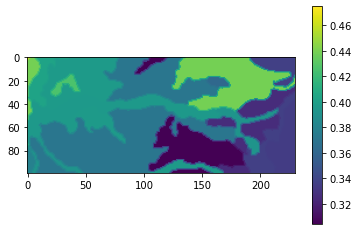

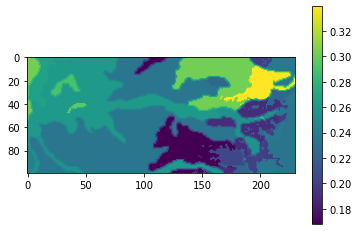

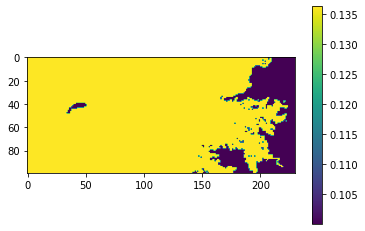

In [517]:
plt.imshow(uzf.thts.array)
plt.colorbar()
plt.show()
plt.imshow(uzf.thtr.array)
plt.colorbar()
plt.show()
plt.imshow(upw.sy.array[0,:,:])
plt.colorbar()
plt.show()

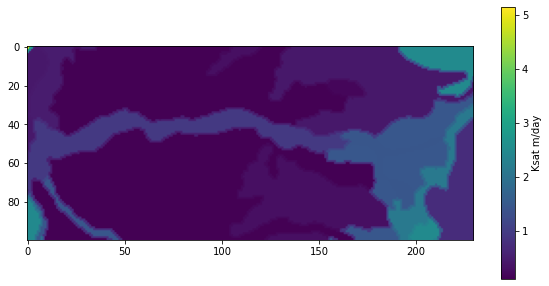

In [518]:

fig, ax = plt.subplots(figsize = (10,10))
plt.imshow(soilKs_array)
plt.colorbar(label = 'Ksat m/day', shrink = 0.5)
# plt.savefig('Plots/Model_SFR_UZF_Progress/Ksat_from_soil_map.png', dpi = 300)

### Crop coefficients and ETo

In [519]:
# crop_path = uzf_path+'\\Oversized_rectangle_2007_2019'
crop_path = uzf_path+'\\Newmodeldomain_cropdata_2007_2019'

import pathlib

crop_raster_list = list(pathlib.Path(crop_path).glob('*.tif'))

crop_dbf = gpd.read_file(crop_path+'\\CDL_2018_clip_20201020153149_1205888229.tif.vat.dbf')
crop_dbf1 = gpd.read_file(crop_path+'\\CDL_2007_clip_20201020153149_1205888229.tif.vat.dbf')


In [520]:
# A-B, A-C, A-D are the percent of the season for each Kc
# The dates are the dates of the growing season
Kc = pd.read_csv(uzf_path+'\\Kc\\Kc_Current.csv',skiprows = 1)
Kc = Kc.rename(columns={'Unnamed: 0' : 'Match_kc'})

In [521]:
def crop_raster2array(file_name, Kc):
    src = rasterio.open(file_name)
    band1 = src.read(1)
    band1 = band1.astype('int16')
    band1 = band1.astype(float)
    band3 = band1.reshape(1, band1.shape[0], band1.shape[1])[:,:,:]
    # turn the rasterio format into a flopy format
    # for some reason flopy will not directly read in the raster .tif
    croprio = Raster(band3, bands = (1,), crs = src.crs, transform = src.transform, 
                 nodataval = 255)
    # crop the raster to the model domain
    croprio.crop(vertices, invert=False)
    
    # The original crop raster has a cell size of 56 by 56 m so if there are less than 4 cells of one crop
    # then for certain they will not fill one cell and most likely have minimal impact considering there are 
    # 6300 model cells in one layer
    crop_hist = np.histogram(band3, bins = np.arange(0,257))
    crops_in_domain = crop_hist[1][:-1][crop_hist[0]>4]

    domain_dbf = crop_dbf.iloc[crops_in_domain]

    domain_dbf['CLASS_NAME'] = domain_dbf.CLASS_NAME.str.replace('Dbl Crop ','')
    domain_dbf['crop_hist'] = crop_hist[0][crops_in_domain]
    Kcmatch = pd.read_csv(uzf_path+'\\Kc\\Cosumnes_crops.csv', index_col = 0)

    # domain_dbf['crop1'] = domain_dbf.CLASS_NAME.str.split('/', expand = True)[0]
    # domain_dbf['crop2'] = domain_dbf.CLASS_NAME.str.split('/', expand = True)[1]

    domain_dbf = domain_dbf.merge(Kcmatch, on = 'CLASS_NAME')
    domain_dbf = domain_dbf.merge(Kc, left_on = 'Match_kc', right_on = 'Match_kc', how = 'left')
    return(croprio, domain_dbf)


In [522]:
croprio, domain_dbf = crop_raster2array(crop_raster_list[-2], Kc)

C:\Users\ajcalder\anaconda3\envs\geosp\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [523]:
## Before resampling to the grid, I need to convert from a crop label with integer format to
## a crop coefficient format that is a float that can be weighted by the number of cells

In [524]:
## Potential ETo spatial interpolation from CIMIS
# daily_data = pd.read_csv(uzf_path+'\\Cosumnes_daily_multistations.csv',index_col = ['Date'], parse_dates = True)
daily_data = pd.read_csv(uzf_path+'\\Cosumnes_dailyET_precip_2010_01_01_to_2019_12_31.csv',index_col = ['Date'], parse_dates = True)

coords = pd.read_csv(uzf_path+'\\CIMIS_station_lat_long.csv', index_col = 0)
coords = gpd.GeoDataFrame(coords,geometry = gpd.points_from_xy(coords['Long'] ,coords['Lat']))
# Convert WGS Lat and long to Easting and Northing in Zone 10N
coords.crs = 'epsg:4326'
coords = coords.to_crs('epsg:32610')

# clean up data so columns are by location, units of ETo are in mm
ET = daily_data.pivot_table(index = 'Date', columns = ['Stn Id', 'Stn Name', 'CIMIS Region'], values = 'ETo (mm)')
ET.iloc[-1:-10:-1].values.shape

# clean up data so columns are by location, units of Precip are in mm
rain = daily_data.pivot_table(index = 'Date', columns = ['Stn Id', 'Stn Name', 'CIMIS Region'], values = 'Precip (mm)')
rain.iloc[-1:-10:-1].values.shape
# there are quite a few days missing rainfall at one station, could generally assume those are zero rain days

(9, 9)

# Need to fix missing rainfall/ET data
temporary fix for now is to set any missing data to zero

Text(0, 0.5, 'Number of days with CIMIS data')

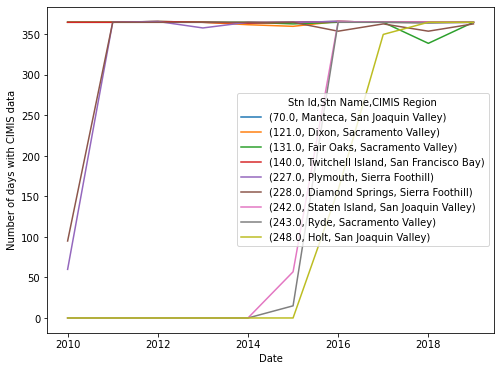

In [527]:
# rain.loc[rain.index > '2018-01-01'].iloc[34:40]
# Check on missing rain data, Ryde, Holt, and Staten Island aren't installed until 2015... need to find more stations
fig, ax = plt.subplots(figsize = (8,6))
rain.groupby(rain.index.year).count().plot(ax=ax)

plt.ylabel('Number of days with CIMIS data')
# plt.savefig('Plots/Model_SFR_UZF_progress/cimis_stations_data_availability.png', dpi = 600, bbox_inches='tight')

# Same situation for ET
# ET.groupby(rain.index.year).count().plot()

In [528]:
# code will need to be removed and the data actually fixed
rain = rain.fillna(0)
ET = ET.fillna(0)

In [529]:
ncell = nrow*ncol

# Filter ET, precip data for the strt_date and end_date of the model stress periods
ET_spd = ET.loc[strt_date:end_date]
rain_spd = rain.loc[strt_date:end_date]

# Get the xy cell centers for the model grid
xy = np.append(mg.xyzcellcenters[0],mg.xyzcellcenters[1], axis = 0)
# reshape the xy data
out_xy = np.transpose(np.vstack([np.reshape(xy[0:nrow], ncell),np.reshape(xy[nrow:],ncell)]))
out_xy.shape, xy.shape
# out_xy

from scipy.interpolate import griddata
in_xy = np.transpose(np.vstack([coords.geometry.x.values, coords.geometry.y.values]))
# Final reshaped array of interpolated ET
ET_final = np.zeros((len(ET_spd), nrow, ncol))
rain_final = np.zeros((len(rain_spd), nrow, ncol))

for i in np.arange(0,len(ET_spd)):
    ET_grid = griddata(in_xy, ET_spd.iloc[i].values, xi = out_xy, method = 'cubic')
    ET_final[i,:,:] = np.reshape(ET_grid, (nrow,ncol))
    rain_grid = griddata(in_xy, rain_spd.iloc[i].values, xi = out_xy, method = 'cubic')
    rain_final[i,:,:] = np.reshape(rain_grid, (nrow,ncol))

# plt.imshow(test)
# plt.colorbar()

# plt.savefig('Plots/Model_SFR_UZF_Progress/ETo distribution in mm_day.png', dpi = 300)

In [530]:
# convert from unis of mm to meters
rain_final = rain_final/1000
rain_final.shape
# correct for any interpolated values that set rainfall to less than 0
rain_final[rain_final<0] = 0

0.0015963796606552195

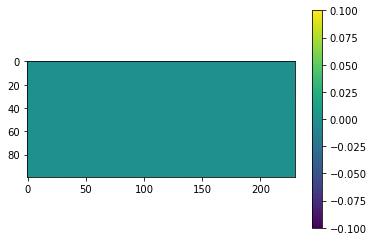

In [531]:
i = 1
# i += 1
plt.imshow(rain_final[i,:,:])
plt.colorbar()
np.nanmean(rain_final)

0

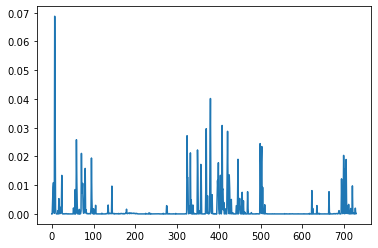

In [532]:
np.histogram(np.isnan(rain_final))
# there are still 920,000 cells with nans
daily_domain_avg = np.mean(np.mean(rain_final, axis = 2),axis = 1)
plt.plot(daily_domain_avg)
np.sum(np.isnan(daily_domain_avg))
# there are 40 days without data, but are mostly late summer so it should be okay to count as zeros for now

In [533]:
# t0 = time.time()
crop_data = croprio.resample_to_grid(m.modelgrid.xcellcenters,
                                m.modelgrid.ycellcenters,
                                band=croprio.bands[0],
                                method="nearest")
# resample_time = time.time() - t0
# print("Resample time, nearest neighbor: {:.3f} sec".format(time.time() - t0))

In [534]:
domain_dbf.columns
# def calc_kc_dates(i):
# The year for each crop for each set of dates needs to change iteratively for each crop individually because
# some crops have dates that extend into the next year that must not change until the final date of the 
# season is reached (e.g. 2018-11-01 to 2019-09-17 must stay 2018 and 2019 until 2019-09-17 is reached)
i = 2018
dates = domain_dbf.loc[:,['Beg Month','Beg Day', 'End Month', 'End Day', 'A-B', 'A-C', 'A-D']]

# Set the pandas datetime from the start and end dates of crops
dates['A'] = pd.to_datetime({'year': i, 'month':dates['Beg Month'].values, 'day': dates['Beg Day'].values})
dates['E'] = pd.to_datetime({'year': i, 'month':dates['End Month'].values, 'day': dates['End Day'].values})
# Make correction for any end dates that are in the next year
dates.E.loc[dates.E < dates.A] = dates.E.loc[dates.E < dates.A] + pd.offsets.DateOffset(years=1)

# Get the length of the growing periods
dates['num_days'] = dates.E-dates.A

# set the end date of growing period A/ start of period B
dates['B'] = dates.A + dates.num_days*(dates['A-B']/100)
# Round the dates, as we will be one a daily time step
dates.B = pd.to_datetime(dates.B.dt.date)

# # set the end date of growing period B/ start of period C
dates['C'] = dates.B + dates.num_days*((dates['A-C']-dates['A-B'])/100)

# # set the end date of growing period C/ start of period D
dates['D'] = dates.C + dates.num_days*((dates['A-D']-dates['A-C'])/100)


C:\Users\ajcalder\anaconda3\envs\geosp\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [535]:
# ET with crop coefficients will be the same dimension as the ETo
ETc = ET_final.copy()
# set to zero initially
ETc[:,:,:] = 0
time = 0

domain_dbf['Kc'] = 0
for y in np.arange(pd.to_datetime(strt_date).year, pd.to_datetime(end_date).year+1):
    # set start and end date for range for the year to be iterated over
    yr_strt = pd.to_datetime(str(y)+'-01-01')
    yr_end = pd.to_datetime(str(y)+'-12-31')
    if yr_strt < pd.to_datetime(strt_date):
        yr_strt = pd.to_datetime(strt_date)
    if yr_end > pd.to_datetime(end_date):
        yr_end = pd.to_datetime(end_date)
        
    for dt in pd.date_range(yr_strt, yr_end):
        # First step is to get the current Kc for each crop for the time step
        domain_dbf.Kc.loc[dt > dates.A] = domain_dbf.loc[dt > dates.A, 'Kc1']
        domain_dbf.Kc.loc[dt > dates.B] = domain_dbf.loc[dt > dates.B, 'Kc2']
        domain_dbf.Kc.loc[dt > dates.C] = domain_dbf.loc[dt > dates.C, 'Kc3']
        domain_dbf.Kc.loc[dt > dates.D] = domain_dbf.loc[dt > dates.D, 'Kc4']
        domain_dbf.Kc.loc[dt > dates.E] = domain_dbf.loc[dt > dates.E, 'Kc4']
        for i,j in zip(domain_dbf.VALUE.values, domain_dbf.Kc.values):
            ETc[time,crop_data==i] = j
        ETc[time,:,:] = ETc[time,:,:]*ET_final[time,:,:]
        time += 1


In [536]:
# Keys correspond to the stress periods
keys = np.arange(0,nper-1).astype(int)
# Remove any na values and replace with zeros 
rain_final[rain_final<0] = 0
# Input each array for each corresponding stress period
ETc_dict = {k: ETc[k,:,:] for k in keys}
# Convert any rain values less than zero due to interpolation to zero
rain_final[rain_final<0] = 0
rain_dict = {k: rain_final[k,:,:] for k in keys}

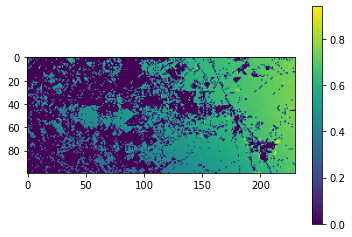

In [537]:
plt.imshow(ETc[1,:,:])
plt.colorbar()

## Adjusting ETc data
For now set any ETc value that is NA to simply 0 ETc. It is mainly the developed land that doesn't have crop coefficients anyway and they normally wouldn't transpire. Rather than try to estimate Kc for developed land, one can simply remove any infiltration from rain and any ETc, assuming that all rainfall runs off to sewer systems that discharge out of the model domain or is quickly evaporated.

In [538]:
# nuzf1>=0 infiltration rates are specified, nuzf1 <0 infil rates from
# previous stress period are used
# infiltration rates (L/T) at land surface
uzf.finf = rain_dict
# Potential ET (L/T)
# average ETo for CA zone 14 is 57.0 in/month, below is a list from Jan-Dec of in/month
# ETo = np.array([1.55, 2.24, 3.72, 5.10, 6.82, 7.80, 8.68, 7.75, 5.70, 4.03, 2.10, 1.55])
# ETo = ETo*(2.54/30) # convert to cm/day roughly
# print(ETo, np.mean(ETo))

uzf.pet = ETc_dict

# Keys correspond to the stress periods
keys = np.arange(0,nper-1).astype(int)
rain_dict = {k: rain_final[k,:,:] for k in keys}
# ET extinction depths (L)
# relatively deep for vines, but what about the rest of ag in the basin?
# Need to get crop maps to estimate PET, EXTDEP and soil maps for FINF
uzf.extdp = 1.5
# Extinction water content, (THTS-Sy) < extwc < THTS
uzf.extwc = 0.15

## Well Package


In [594]:
wells = pd.read_csv(gwfm_dir+'/WEL_data/all_wells_type.csv')
wells_grid = gpd.GeoDataFrame(wells, geometry = gpd.points_from_xy(wells.easting,wells.northing), crs = 'epsg:32610')

In [595]:
print('Number of wells:', wells_grid.shape[0])
print('Numer of cells with wells:', wells_grid.dissolve('node', aggfunc = 'mean').shape[0])
print('Number of ag wells:', wells_grid.loc[wells_grid.Simple_type == 'irrigation'].dissolve('node', aggfunc = 'mean').shape[0])


Number of wells: 2166
Numer of cells with wells: 1298
Number of ag wells: 140


In [596]:
wells_grid_ag = wells_grid[:]
wells_grid_ag = wells_grid.loc[wells_grid.Simple_type == 'irrigation'].dissolve('node', aggfunc = 'mean')
wells_grid_ag.geometry = wells_grid.loc[wells_grid.Simple_type == 'irrigation'].dissolve('node', aggfunc = 'first').geometry

In [598]:
WCRNumbers = wells_grid.loc[wells_grid.Simple_type == 'irrigation'].dissolve('node', aggfunc = 'first').WCRNumber.values
temp = wells_grid[:]
temp = temp.set_index('WCRNumber')
# temp_geometry = temp.loc[nodes].geometry

<AxesSubplot:>

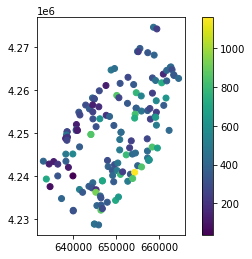

In [599]:
wells_grid.loc[wells_grid.Simple_type == 'irrigation'].dissolve('node', aggfunc = 'mean').plot('TotalCompletedDepth',legend=True)

In [600]:
wells_grid_tcd_mean = wells_grid.loc[wells_grid.Simple_type == 'irrigation'].dissolve('node', aggfunc = 'mean')

In [601]:
wells_grid['depth_m'] = wells_grid.TotalCompletedDepth*0.3048


In [602]:
# drop wells that have a total depth below the bottom of the model
model_botm_wells = botm[-1, :, :][wells_grid.row.values.astype(int)-1,wells_grid.column.values.astype(int)-1] 
well_bottoms = dem_data[wells_grid.row.values.astype(int)-1,wells_grid.column.values.astype(int)-1]-wells_grid.depth_m.iloc[i]
print('There are %0.f wells below the model bottom' %(well_bottoms < model_botm_wells).sum())
wells_grid = wells_grid.loc[(well_bottoms > model_botm_wells).values]

There are 296 wells below the model bottom


In [603]:
wells_grid['flux'] = 0
wells_grid['layer'] = 0

C:\Users\ajcalder\anaconda3\envs\geosp\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [604]:
# gpm to m^3/day, standard pumping rate is 500-1500 gpm for agricultural wells avg of 1000, maybe should be a bit lower
# that's assuming it's run 24 hours a day, they are probably usually only run for a few hours each day?
# 1000 gpm * (1 ft^3/ 7.48 gal) (ft^3/m^3)*60 min hour* 6 hours in a day* 30 days

irrig_flux = 1000*(1/7.48)*(0.3048**3)*60*6*30

# assume each public supply well serves 10,000 people each needing 50 gpd, then need to convert to ft^3
public_flux = (10000*50*30/7.48)*(0.3048**3)
# public_flux = 1500*(1/7.48)*(0.3048**3)*60*24*30

# averge pumping rate of domestic wells is 10-100 gpm, typically on the lower end and 
# should end up being around 50 gal/person a day and average 3 people is 150 gal/day
# 10 gpm * (1 ft^3/ 7.48 gal) (ft^3/m^3)*60 min hour* 3 hours in a day * 30 days

dom_flux = 30*(1/7.48)*(0.3048**3)*60*24*30
print('Irrig flux:', '%.3e' % irrig_flux, 'Public flux:', '%.3e' %public_flux,'Domestic flux:', '%.3e' %dom_flux)

Irrig flux: 4.089e+04 Public flux: 5.679e+04 Domestic flux: 4.906e+03


In [605]:
# define pumping rate based on well use, average pumping rate in m^3/day
# wells_grid.loc[wells_grid.PlannedUseFormerUse == 'irrigation', 'flux'] = -irrig_flux
# wells_grid.loc[wells_grid.PlannedUseFormerUse == 'domestic', 'flux'] = -dom_flux
# wells_grid.loc[wells_grid.PlannedUseFormerUse == 'public', 'flux'] = -irrig_flux


wells_grid.loc[wells_grid.Simple_type == 'irrigation', 'flux'] = -irrig_flux
wells_grid.loc[wells_grid.Simple_type == 'domestic', 'flux'] = -dom_flux
wells_grid.loc[wells_grid.Simple_type == 'public', 'flux'] = -public_flux

In [606]:
if wells_grid.row.min()==1:
    wells_grid.row = (wells_grid.row-1).astype(int)
    wells_grid.column = (wells_grid.column -1).astype(int)

In [607]:
mean_ag_well_depth = wells_grid.loc[wells_grid.Simple_type == 'irrigation'].TotalCompletedDepth.mean()*0.3048
mean_ag_well_depth

127.9980705882353

In [608]:

for k in np.arange(0,nlay-1):
    # pull out elevation of layer bottom
    lay_elev = botm[k, :, :]
    for i in np.arange(0,len(wells_grid)):
        # want to compare if streambed is lower than the layer bottom
        # 1 will be subtracted from each z value to make sure it is lower than the model top in the upper reaches
        if lay_elev[wells_grid.row.values[i],wells_grid.column.values[i]] > dem_data[wells_grid.row.values[i],wells_grid.column.values[i]]-wells_grid.depth_m.iloc[i]:
            wells_grid.layer.iloc[i] = k     

C:\Users\ajcalder\anaconda3\envs\geosp\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\ajcalder\anaconda3\envs\geosp\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [609]:
print('Cells with wells: ', wells_grid.dissolve(by='node',aggfunc='first').shape[0], 'total wells: ', wells_grid.shape[0])
print('Wells with TRS accuracy: ', (wells_grid.MethodofDeterminationLL == 'Derived from TRS').sum())

wells_grid_notrs = wells_grid.loc[wells_grid.MethodofDeterminationLL != 'Derived from TRS']

Cells with wells:  1122 total wells:  1870
Wells with TRS accuracy:  477


There are around 1000 wells that coexist in a cell with another well, but there are only 562 wells with TRS accuracy. This suggests that there are about 500 wells where they truly are within one cell distance, but are most likely domestic wells.

C:\Users\ajcalder\anaconda3\envs\geosp\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


1.0 1.3764822134387351 7


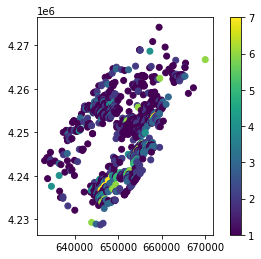

In [619]:
wells_grid_notrs['count_per_cell'] = 1
# all_wells_grid['MFCell'] = all_wells_grid.Township+all_wells_grid.Range+all_wells_grid.k.astype(str)
wells_grid_sum = wells_grid_notrs.dissolve(by = 'node', aggfunc='sum')
wells_grid_sum.plot('count_per_cell',legend=True)
print(wells_grid_sum.count_per_cell.median(), wells_grid_sum.count_per_cell.mean(), wells_grid_sum.count_per_cell.max())


4906.234382785025 40885.28652320855 56785.120171123


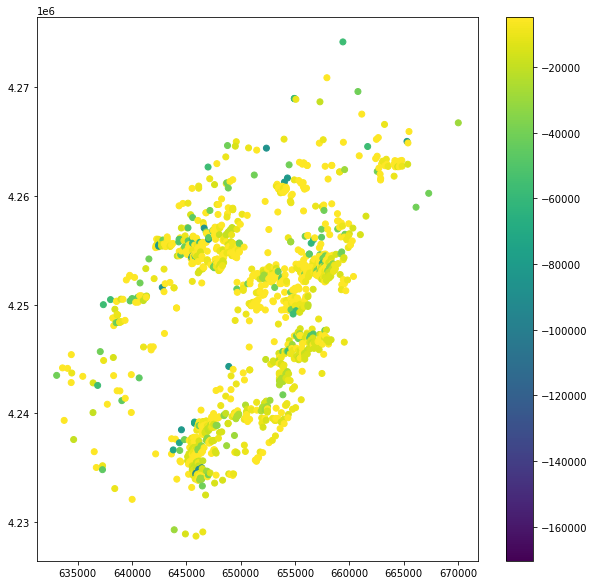

In [620]:
fig, ax = plt.subplots(figsize = (10,10))

wells_grid_sum.plot('flux', ax=ax, legend=True)
print(dom_flux, irrig_flux, public_flux)

In [195]:


# save domestic, public wells for their pumping doesn't depend on ET
wells_grid_no_ag = wells_grid.loc[wells_grid.Simple_type != 'irrigation']

In [207]:
# copy model grid for well ag pumping based on ET
well_ag_ET = grid_p[:]

In [216]:
well_ag_ET.loc[:,'depth_m'] = mean_ag_well_depth
# temporarily hardset, need to change later
well_ag_ET.loc[:,'layer'] = 0


In [226]:
for k in np.arange(0,nlay):
    # pull out elevation of layer bottom
    lay_elev = botm[k, :, :]
    for i in np.arange(0,len(well_ag_ET)):
        # want to compare if streambed is lower than the layer bottom
        # 1 will be subtracted from each z value to make sure it is lower than the model top in the upper reaches
        if lay_elev[well_ag_ET.row.values[i]-1,well_ag_ET.column.values[i]-1] > dem_data[well_ag_ET.row.values[i]-1,well_ag_ET.column.values[i]-1]-well_ag_ET.depth_m.iloc[i]:
            well_ag_ET.layer.iloc[i] = k   

C:\Users\ajcalder\anaconda3\envs\geosp\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\ajcalder\anaconda3\envs\geosp\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [622]:
# Create a list of the items needed for the stress period data from the geopandas dataset
# spd_gdf = wells_grid.loc[:,['layer','row','column', 'flux']]
spd_gdf = wells_grid_notrs.loc[:,['layer','row','column', 'flux']]

spd_gdf = spd_gdf.dropna()

In [623]:
spd_gdf_array = spd_gdf.values
# lay, row, col, head, cond
k = spd_gdf_array[:,0].astype(int)
i = spd_gdf_array[:,1].astype(int)
j = spd_gdf_array[:,2].astype(int)

# find where the ghb overlaps with the no flow cells
active_bc =ibound[k,i,j]
spd_gdf_array=spd_gdf_array[:][active_bc.astype(bool)]

In [624]:
# correct for wells that are too close to the model boundaries
# within 5 rows of the edges
print('There are ',(spd_gdf_array[:,1]<=2).sum()+(spd_gdf_array[:,1]>=97).sum(), 'wells within 3 rows of the model NE<SW edges')
spd_gdf_array = spd_gdf_array[spd_gdf_array[:,1]>2]
spd_gdf_array = spd_gdf_array[spd_gdf_array[:,1]<97]

There are  44 wells within 3 rows of the model NE<SW edges


## Scale Wel package by 10 to see if model runs better
Model ran all the way through with a 1/10 reduction in all pumping.
Next test is to see if just reducing ag well pumping helps or if removing duplicate wells at a single cell helps

In [199]:
# spd_gdf_array[:,-1] *= 10

In [379]:
# use ET data from CIMIS on monthly basis to estimate ag pumping
# use average ag well depth as a starting point
if np.min(well_ag_ET.row) >0:
    i = well_ag_ET.row = well_ag_ET.row-1
    j = well_ag_ET.column = well_ag_ET.column-1
well_ag_ET_array = well_ag_ET.loc[:,['layer','row','column']]
# multiply the L/T ET rate by the cell area to get the total volumetric flux
ET_pump = ET_final*200*200

# Create a dictionary for the stress periods
# have transient well_data start after the 1st spd
# spd = { t: np.append(spd_gdf_array,np.column_stack((well_ag_ET_array, ET_final[t-1,i, j])),axis=0) for t in np.arange(1,nper)}
# only ET based
spd = { t: np.column_stack((well_ag_ET_array, ET_pump[t-1,i, j])) for t in np.arange(1,nper)}

# spd = { 0: spd_gdf.values}

In [625]:
spd = { t: spd_gdf_array for t in np.arange(1,nper)}


In [626]:
# Create well flopy object
wel = flopy.modflow.ModflowWel(m, stress_period_data=spd)

****Warning -- two packages of the same type:  <class 'flopy.modflow.mfwel.ModflowWel'> <class 'flopy.modflow.mfwel.ModflowWel'>
replacing existing Package...


## Tabfile set up for SFR


In [555]:
# For the tab files the left column is time (in model units) and the right column is flow (model units)
# Time is days, flow is cubic meters per day
import numpy as np
import pandas as pd
# USGS presents flow in cfs (cubic feet per second)
inflow = pd.read_csv(sfr_dir+'MB_daily_flow_cfs_2011_2019.csv', index_col = 'datetime', parse_dates = True)

# filter out data between the stress period dates
inflow = inflow.loc[strt_date:end_date]
# covnert flow from cubic feet per second to cubic meters per day
inflow['flow_cmd'] = inflow.flow_cfs * (86400/(3.28**3))

# # np.arange(0,len(flow_cmd))
time_flow = np.vstack((np.arange(0,len(inflow.flow_cmd)),inflow.flow_cmd))
time_flow = np.transpose(time_flow)
np.savetxt('data/MF.tab',time_flow, delimiter = '\t')

In [556]:
# the threshold is 23m^3/s
23*(86400)/1e6, inflow.flow_cmd.min(), inflow.flow_cmd.mean(),inflow.flow_cmd.median()

(1.9872, 33543.840048751474, 1680346.8205507481, 340335.3114435369)

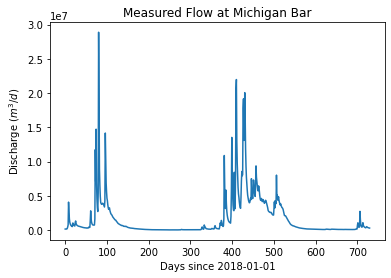

In [557]:
plt.plot(time_flow[:,0],time_flow[:,1])
plt.xlabel('Days since '+strt_date)
plt.ylabel('Discharge ($m^3/d)$')
plt.title('Measured Flow at Michigan Bar')
plt.ticklabel_format(style='scientific') # or plain for all zeros

# plt.savefig('Plots/Model_SFR_UZF_Progress/dailyflow_MB.png', dpi = 300, bbox_inches='tight')

### Add the outside TAB file for SFR Package

In [558]:
# Only needs to be run one time
flopy.modflow.mfaddoutsidefile(model = m, name = 'DATA',extension = 'tab',unitnumber = 56)

Outside Package class

### Lake Bathymetry file set up

   OID_   Shape_Leng    Shape_Area  HydroID  MaxElev  MinElev  UserElev  \
0     0  9453.899233  2.078432e+06     2137  11.5702   2.9779       0.0   

                                            geometry  
0  POLYGON ((642539.493 4242823.298, 642529.571 4...  
The minimum lake stage is 4.83234365913772 m at which there is no water ponding


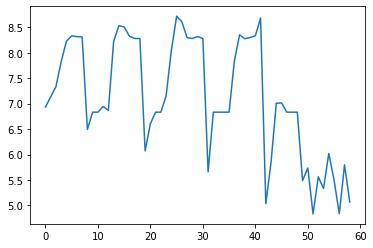

In [559]:
# Exactly 151 lines must be included within each lake bathymetry input file and each line must contain 1 value 
#  of lake stage (elevation), volume, and area (3 numbers per line) if the keyword “TABLEINPUT” is specified in item 1a.
# A separate file is required for each lake. 
# For oneto-denier, the levees are relatively vertical and on the very most exterior such that the lake area changes
# very litle for any change in stage
# It may be of interest to subset the lakes to have varying elevaion

# the initial stage of each lake at the beginning of the run
lak_elev = dem_data[gplak2D.row-1, gplak2D.column-1]
# minimum elevation based on resampled model dem because lake stage shouldn't be below the lowest cell
lak_elev_min = np.min(lak_elev)
# maximum stage based on data from the 2m DEM because max stage shouldn't be above the levees and
# the model dem doesn't capture the effect of the levees
lak_elev_max = lak2D.MaxElev.values[0]
stages = lak_elev_min+0.1
# (ssmn, ssmx) max and min stage of each lake for steady state solution, there is a stage range for each lake
# so double array is necessary
stage_range = [[lak_elev_min, lak_elev_max]]
print(lak2D)
# gplak2D
plt.plot(dem_data[gplak2D.row-1, gplak2D.column-1])
print('The minimum lake stage is', np.min(dem_data[gplak2D.row-1, gplak2D.column-1]), 
      'm at which there is no water ponding')



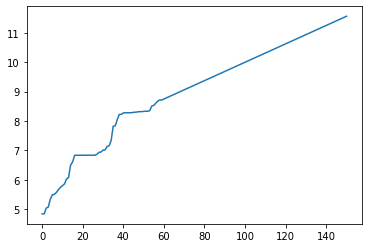

In [560]:
# for i in np.arange(0,151):
np.sort(lak_elev)
len(lak_elev)
lak_stage = np.append(np.sort(lak_elev), np.linspace(np.max(lak_elev),lak_elev_max, num = 151-len(lak_elev)))
plt.plot(lak_stage)

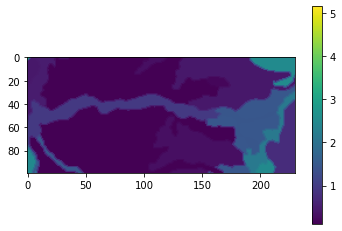

In [561]:
# nonzero = lakarr > 0
# bdlknc = np.zeros((nrow,ncol))
temp = np.zeros((nper, nlay, nrow,ncol))
# Calculate bed leakance based on soil maps K representative values
# temp[:,:, grid_uzf.row.values-1,grid_uzf.column.values-1] = grid_uzf.Ksat_Rep.values
temp[:,:,:] = soilKs_array
bdlknc = temp[0,:,:,:]

bdlknc.shape
plt.imshow(bdlknc[0,:,:])
plt.colorbar()
# lak.bdlknc.array.shape

## Create the bathymetry file for the LAK package

Becase the grid resolution is so coarse, there are both levee and floodplain cells in each grid cell that lead to the nearest cell being sampled to be of a much higher elevation than expected

In [562]:
# lake stage (elevation), volume, and area (3 numbers per line)
# for i in np.arange(0,151):
np.sort(lak_elev)
len(lak_elev)
lak_stage = np.append(np.sort(lak_elev), np.linspace(np.max(lak_elev),lak_elev_max, num = 151-len(lak_elev)))
lak_depth = lak_stage - lak_stage[0]
lak_area = np.arange(0,len(lak_elev))*(200*200)
lak_area = np.append(lak_area, lak_area[-1]*np.ones(len(lak_stage) - len(lak_area)))
lak_volume = lak_depth*lak_area
bathtxt = np.column_stack((lak_stage, lak_volume, lak_area))
# lak_area[-1]/1e6, lak2D
# plt.plot(lak_stage)
# for i in np.arange(0,len(lak_stage)):
np.savetxt('data/MF.txt', bathtxt, delimiter = '\t')

In [563]:
## Need to specify flux data
# Dict of lists keyed by stress period. The list for each stress period is a list of lists,
# with each list containing the variables PRCPLK EVAPLK RNF WTHDRW [SSMN] [SSMX] from the documentation.
# flux_data = np.zeros((nrow,ncol))

flux_data = {0:{0:[0,0,0,0]}}

In [564]:
# filler value for bdlknc until soil map data is loaded by uzf
lak = flopy.modflow.ModflowLak(model = m, lakarr = lakarr, bdlknc = bdlknc,  stages=stages, 
                               stage_range=stage_range, flux_data = 0,tabdata= True, 
                               tab_files='MF.txt', tab_units=57)

In [565]:
lak.tabdata = True
lak.iunit_tab


57

In [566]:
# the lak package doesn't specify the tab file unit number when the files are written
# example:      110.0     100.0     170.0   22   Item 3:  STAGES,SSMN,SSMX,IUNITLAKTAB

lak.options = ['TABLEINPUT']
# option block is not yet available for the lake package
# lak_option = flopy.utils.OptionBlock(options_line = 'TABLEINPUT ', package = lak, block = True)


### Add the outside bathymetry text file for LAK package

In [567]:
flopy.modflow.mfaddoutsidefile(model = m, name = 'DATA',extension = 'txt',unitnumber = 57)

Outside Package class

## Output Control

In [568]:
# Output control
# default unit number for heads is 51, cell by cell is 53 and drawdown is 52
# (0,0) is (stress period, time step)

# For later model runs when all the data is needed to be saved
# spd = { (j,0): ['save head', 'save budget'] for j in np.arange(0,nper)}
# # Print the budget in the list file for every 50 time steps to check
# for i in np.arange(0,730,50):
#     spd[(i,0)] = ['print budget', 'save head', 'save budget']

# spd = { (j,0): ['print budget', 'save head', 'save budget'] for j in np.arange(0,nper,int(nper/30))}
spd = { (j,0): ['print budget', 'save head', 'save budget'] for j in np.arange(0,nper,2)}

# test oc 
# spd = { (0,0): ['print budget', 'save head', 'save budget'],
#       (1,0): ['print budget', 'save head', 'save budget']}

    
oc = flopy.modflow.ModflowOc(model = m, stress_period_data = spd, compact = True)

## The model fails to converge on the first time step due to issues with the upper and lower specified head/ghb boundary conditions
One solution is to increase the maximum outer iterations so that they model is able to converge by the first time step

In [569]:
# pcg = flopy.modflow.ModflowPcg(model = m)
# nwt = flopy.modflow.ModflowNwt(model= m)
# thickfact: portion of cell thickness used for smoothly adjusting storage and conductance coefficients to zero (default is 1e-5)
# linmeth (linear method): 1 for GMRES and 2 for XMD (1 is default)
# iprnwt: flag whether additional info about solver convergence will be printed to the main listing file (default is 0)
# ibotav: flag whether corretion will be made to gw head relative to cell-bottom if surrounded by dry cells.
# 1 = corrections and  0 = no correction (default is 0)
# options: specify comlexity of solver. SIMPLE : default solver for linear models, MODERATE for moderately nonlinear models,
# COMPLEX for highly nonlinear models (default is COMPLEX)
# Continue: if model fails to converge during a time step it will continue to solve the next time step (default is False) 
# epsrn (XMD) is the drop tolerance for preconditioning (default is 1E-4)
# hclosexmd (XMD) head closure criteria for inner (linear) iterations (default 1e-4)
nwt = flopy.modflow.ModflowNwt(model = m, headtol=0.0001, fluxtol=500, maxiterout=200, thickfact=1e-05, 
                               linmeth=1, iprnwt=1, ibotav=0, options='COMPLEX', Continue=False,
                               maxbackiter=50, backtol=1.1, maxitinner=50, ilumethod=2, 
                               levfill=5, stoptol=1e-10, msdr=15, iacl=2, norder=1, level=5, north=7, 
                               iredsys=0, rrctols=0.0, idroptol=1, epsrn=0.0001, hclosexmd=0.0001, 
                               mxiterxmd=50, extension='nwt', unitnumber=None, filenames=None)
# GMG is more successful than pcg which is fine for steady state model
# mxiter, max outer, iiter = max inner, hclose = head change criterion for convergence, 
# rclose = residual criterion for convergence

# gmg = flopy.modflow.ModflowGmg(model = m, mxiter=50, iiter=30, hclose = 1e-5, rclose = 1e-5)

In [572]:
m.get_package_list()
# m.remove_package('DATA')
# m.remove_package('UZF')
# m.remove_package('LAK')
# m.remove_package('WEL')
wel.check()


WEL PACKAGE DATA VALIDATION:
  134320 Warnings:
    134320 instances of BC in inactive cell

  Checks that passed:
    BC indices valid
    not a number (Nan) entries



In [571]:
# dis.nstp = dis.nstp.array*2.4
# sfr.plot_path(start_seg = 1, end_seg = 0)
# sfr.plot(key='ireach');
m.check()
# m.check()
# lak.check()
# upw.check()


MF MODEL DATA VALIDATION SUMMARY:
  134323 Warnings:
    BAS6 package: isolated cells in ibound array
    WEL package: BC in inactive cell

  Checks that passed:
    Compatible solver package
    Unit number conflicts
    DIS package: zero or negative thickness
    DIS package: thin cells (less than checker threshold of 1.0)
    DIS package: nan values in top array
    DIS package: nan values in bottom array
    BAS6 package: Not a number
    UPW package: zero or negative horizontal hydraulic conductivity values
    UPW package: zero or negative vertical hydraulic conductivity values
    UPW package: negative horizontal anisotropy values
    UPW package: horizontal hydraulic conductivity values below checker threshold of 1e-11
    UPW package: horizontal hydraulic conductivity values above checker threshold of 100000.0
    UPW package: vertical hydraulic conductivity values below checker threshold of 1e-11
    UPW package: vertical hydraulic conductivity values above checker threshold

## Write the input files

In [304]:
# Writing the MODFLOW data files
m.write_input()


KeyboardInterrupt: 

# Run the model

In [446]:
dis.get_lrc(6011)
dis.get_lrc(420)

[(1, 2, 190)]

In [302]:
success, buff = m.run_model()

FloPy is using the following  executable to run the model: C:\WRDAPP\MODFLOW-NWT_1.2.0\bin\MODFLOW-NWT.EXE

                                  MODFLOW-NWT-SWR1 
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUNDWATER-FLOW MODEL
                             WITH NEWTON FORMULATION
                             Version 1.2.0 03/01/2020                        
                    BASED ON MODFLOW-2005 Version 1.12.0 02/03/2017                       

                    SWR1 Version 1.04.0 09/15/2016                       

 Using NAME file: MF.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2020/12/04 13:50:29

 Solving:  Stress period:     1    Time step:     1    Groundwater-Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2020/12/04 13:55:17
 Elapsed run time:  4 Minutes, 47.713 Seconds

 FAILED TO MEET SOLVER CONVERGENCE CRITERIA            1  TIME(S)
